## Preparing the data

In [241]:
#Loading pacakges

import pandas as pd
import numpy as np
import os 
from glob import glob
from sklearn.preprocessing import MinMaxScaler

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


# Set visualization styles
plt.style.use("ggplot")  
sns.set_palette("coolwarm")

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Data Loading 

The data loading block below is for running the code locally. The raw wearable and activity datasets used in this analysis are not included in this public repo. In the data folder, explanations of each of the data source and their columns are included!

The code below reflects how the data was loaded and processed locally for this analysis but it is not intended to be executed in this version of the notebook. 

In [242]:
#Load Smart Ring Data

#Activity Dataset
# RC_activity=pd.read_csv("RingConnYearData/RC_Activity.csv")
RC_activity['Date'] = pd.to_datetime(RC_activity['Date']).dt.date  

#Sleep Dataset
# RC_sleep=pd.read_csv("RingConnYearData/RC_Sleep.csv")

# Convert 'End Time' to datetime
RC_sleep['End Time'] = pd.to_datetime(RC_sleep['End Time'], errors='coerce')

# Creates a 'Date' column from 'End Time'
RC_sleep['Date'] = RC_sleep['End Time'].dt.date  

# Save the updated dataset
RC_sleep.to_csv("RC_Sleep_with_dates.csv", index=False)

#Vital Signs Dataset
# RC_vital=pd.read_csv("RingConnYearData/RC_VitalSigns.csv")
RC_vital['Date'] = pd.to_datetime(RC_vital['Date']).dt.date  

# Convert 'Date' columns to datetime format
RC_activity['Date'] = pd.to_datetime(RC_activity['Date'], errors='coerce')
RC_sleep['Date'] = pd.to_datetime(RC_sleep['Date'], errors='coerce')
RC_vital['Date'] = pd.to_datetime(RC_vital['Date'], errors='coerce')


In [243]:
#Display the RC columns being kept
print(list(RC_activity.columns))
print(list(RC_sleep.columns))
print(list(RC_vital.columns))

['Date', 'Steps', 'Calories(kcal)']
['Start Time', 'End Time', 'Falling Asleep Time', 'Wake-up time', 'Sleep Time Ratio(%)', 'Time Asleep(min)', 'Sleep Stages - Awake(min)', 'Sleep Stages - REM(min)', 'Sleep Stages - Light Sleep(min)', 'Sleep Stages - Deep Sleep(min)', 'Date']
['Date', 'Avg. Heart Rate(bpm)', 'Min. Heart Rate(bpm)', 'Max. Heart Rate(bpm)', 'Avg. Spo2(%)', 'Min. Spo2(%)', 'Max. Spo2(%)', 'Avg. HRV(ms)', 'Min. HRV(ms)', 'Max. HRV(ms)']


In [244]:
# #Load the Strava dataset
# Strava = pd.read_csv("StraaveData/Strava.csv")

# Check the data type before conversion
print(Strava['Activity Date'].dtype)

# Convert 'Activity Date' to datetime format
Strava['Date'] = pd.to_datetime(Strava['Activity Date'], errors='coerce')
Strava['Date'] = pd.to_datetime(Strava['Date'], errors='coerce')
Strava['Date'] = Strava['Date'].dt.normalize()

print(Strava['Date'].dtype)

# Filter for only year 2024
Strava = Strava[Strava['Date'].dt.year == 2024]

Strava=Strava[Strava['Activity Type']=="Run"]

# Confirm filtering worked
print(Strava.head())  # Display first few rows
print(f"Filtered Strava DataFrame contains {len(Strava)} activities from 2024")



object
datetime64[ns]
     Activity ID              Activity Date  Distance  Activity Name  \
189  10701368382    Feb 5, 2024, 2:27:52 PM      2.18    Morning Run   
190  10737625813    Feb 9, 2024, 9:54:53 PM      2.33  Afternoon Run   
191  10807153946  Feb 21, 2024, 12:34:05 PM      3.03  Daddy Lessons   
192  10841081558   Feb 26, 2024, 2:28:43 PM      3.35    Morning Run   
193  10868900331    Mar 1, 2024, 4:16:22 PM      3.01      Lunch Run   

    Activity Type Activity Description  Elapsed Time  Max Heart Rate  \
189           Run                  NaN          1258           160.0   
190           Run                  NaN          1474           173.0   
191           Run                  NaN          1657           174.0   
192           Run                  NaN          1933           170.0   
193           Run                  NaN          1981           168.0   

     Relative Effort  Commute  ... Total Steps Carbon Saved Pool Length  \
189             25.0    False  ...   

In [331]:
Strava.columns

Index(['Activity ID', 'Activity Date', 'Distance', 'Activity Name',
       'Activity Type', 'Activity Description', 'Elapsed Time',
       'Max Heart Rate', 'Relative Effort', 'Commute', 'Activity Private Note',
       'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight',
       'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade',
       'Average Positive Grade', 'Average Negative Grade', 'Max Cadence',
       'Average Cadence', 'Max Heart Rate.1', 'Average Heart Rate',
       'Max Watts', 'Average Watts', 'Calories', 'Max Temperature',
       'Average Temperature', 'Relative Effort.1', 'Total Work',
       'Number of Runs', 'Uphill Time', 'Downhill Time', 'Other Time',
       'Perceived Exertion', 'Type', 'Start Time', 'Weighted Average Power',
       'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort',
       'Commute.1

In [333]:
print(Strava['Start Time'].head())

189   NaT
190   NaT
191   NaT
192   NaT
193   NaT
Name: Start Time, dtype: datetime64[ns]


In [245]:
Strava['Start Time'] = pd.to_datetime(Strava['Start Time'])
Strava['Start_Minutes'] = Strava['Start Time'].dt.hour * 60 + Strava['Start Time'].dt.minute

In [332]:
Strava.count()

Activity ID      94
Activity Date    94
Distance         94
Activity Name    94
Activity Type    94
                 ..
Timer Time        0
Total Cycles      0
Media            42
Date             94
Start_Minutes     0
Length: 96, dtype: int64

In [247]:
#Filter to only keepo certain Strava columns
print(list(Strava.columns))
selected_columns=['Date', 'Activity Name', 'Activity Type', 'Distance', 'Moving Time', 'Max Heart Rate', 'Relative Effort', 'Average Heart Rate', 'Weather Temperature', 'Humidity', 'Apparent Temperature', 'Elapsed Time', 'Max Speed', 'Average Speed',
                  'Start Time', 'Elevation Gain', 'Elevation Loss', 'Average Cadence', 'Average Grade Adjusted Pace', 'Start_Minutes']

#Create df called Strava_select 
Strava_select=Strava[selected_columns]
print(Strava_select.head())

['Activity ID', 'Activity Date', 'Distance', 'Activity Name', 'Activity Type', 'Activity Description', 'Elapsed Time', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Average Positive Grade', 'Average Negative Grade', 'Max Cadence', 'Average Cadence', 'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts', 'Calories', 'Max Temperature', 'Average Temperature', 'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time', 'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type', 'Start Time', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1', 'Total Weight Lifted', 'From Upload', 'Grade Adjusted Distance', 'Weather Observation Time', 'Weather

In [248]:
Strava_select.columns

Index(['Date', 'Activity Name', 'Activity Type', 'Distance', 'Moving Time',
       'Max Heart Rate', 'Relative Effort', 'Average Heart Rate',
       'Weather Temperature', 'Humidity', 'Apparent Temperature',
       'Elapsed Time', 'Max Speed', 'Average Speed', 'Start Time',
       'Elevation Gain', 'Elevation Loss', 'Average Cadence',
       'Average Grade Adjusted Pace', 'Start_Minutes'],
      dtype='object')

In [249]:
#Check data types of all individual dfs before merging
print("RC_activity Date type:", RC_activity['Date'].dtype)
print("RC_sleep Date type:", RC_sleep['Date'].dtype)
print("RC_vital Date type:", RC_vital['Date'].dtype)
print("Strava Date type:", Strava_select['Date'].dtype)


RC_activity Date type: datetime64[ns]
RC_sleep Date type: datetime64[ns]
RC_vital Date type: datetime64[ns]
Strava Date type: datetime64[ns]


In [250]:
# # Merge all datasets on 'Date'
# master_df = RC_activity.merge(RC_sleep, on="Date", how="outer") \
#                        .merge(RC_vital, on="Date", how="outer") \
# #                        .merge(RC_activity, on="Date", how="outer")\
# #                        .merge(Strava_select[['Date','Relative Effort', 'Max Heart Rate', 'Activity Name', 'Activity Type', 'Distance', 'Average Heart Rate','Weather Temperature', 'Humidity', 'Apparent Temperature']], on="Date", how="left")
#                        .merge(Strava_select, on="Date", how="left")


In [251]:
# Merge all datasets on 'Date'
master_df = (
    RC_activity.merge(RC_sleep, on="Date", how="outer")
               .merge(RC_vital, on="Date", how="outer")
               .merge(Strava_select, on="Date", how="left")
)

In [252]:
master_df.columns
master_df.shape

(314, 41)

In [253]:
# #Eliminate rows that don't have any RingConn data recorded
master_df = master_df.dropna(subset=['Start Time_x'])
master_df.shape

(304, 41)

In [254]:
#Dealing with the relative effort metric

#Replace NaN relative effort values with 0s
#If no running workout was completed for that day, then the relative workout effort for that day is 0
master_df['Relative Effort'] = master_df['Relative Effort'].fillna(0)

#Shift the relative effort column by 1 day so that the recovery score will be based on yesterday's strain rather than the strain of the current day
master_df['Prev Day Relative Effort'] = master_df['Relative Effort'].shift(1)

In [255]:
# Display first few rows to confirm merge success
print(master_df.head(50))

         Date    Steps  Calories(kcal)         Start Time_x  \
1  2024-05-02  16268.0          1542.0  2024-05-02 02:32:20   
2  2024-05-03  11781.0          1490.0  2024-05-03 00:55:58   
3  2024-05-04   5691.0          1271.0  2024-05-04 00:31:40   
4  2024-05-05   8356.0          1504.0  2024-05-04 22:46:08   
5  2024-05-06  12843.0          1404.0  2024-05-05 23:31:37   
6  2024-05-07   9786.0          1499.0  2024-05-06 23:25:49   
7  2024-05-08   6167.0          1312.0  2024-05-07 23:48:07   
8  2024-05-09   9529.0          1360.0  2024-05-08 23:17:04   
9  2024-05-10  20979.0          1913.0  2024-05-09 23:25:14   
10 2024-05-11  12539.0          1401.0  2024-05-11 01:24:32   
11 2024-05-12  12623.0          1513.0  2024-05-11 23:17:59   
12 2024-05-13  16998.0          1708.0  2024-05-13 00:04:38   
13 2024-05-14   8961.0          1397.0  2024-05-13 23:16:31   
14 2024-05-15  15012.0          1654.0  2024-05-14 23:57:55   
15 2024-05-16   7582.0          1393.0  2024-05-15 23:5

In [256]:
#Printing the list of all of the columns in the master df
print(list(master_df.columns))

['Date', 'Steps', 'Calories(kcal)', 'Start Time_x', 'End Time', 'Falling Asleep Time', 'Wake-up time', 'Sleep Time Ratio(%)', 'Time Asleep(min)', 'Sleep Stages - Awake(min)', 'Sleep Stages - REM(min)', 'Sleep Stages - Light Sleep(min)', 'Sleep Stages - Deep Sleep(min)', 'Avg. Heart Rate(bpm)', 'Min. Heart Rate(bpm)', 'Max. Heart Rate(bpm)', 'Avg. Spo2(%)', 'Min. Spo2(%)', 'Max. Spo2(%)', 'Avg. HRV(ms)', 'Min. HRV(ms)', 'Max. HRV(ms)', 'Activity Name', 'Activity Type', 'Distance', 'Moving Time', 'Max Heart Rate', 'Relative Effort', 'Average Heart Rate', 'Weather Temperature', 'Humidity', 'Apparent Temperature', 'Elapsed Time', 'Max Speed', 'Average Speed', 'Start Time_y', 'Elevation Gain', 'Elevation Loss', 'Average Cadence', 'Average Grade Adjusted Pace', 'Start_Minutes', 'Prev Day Relative Effort']


In [257]:
# Replace spaces with underscores in all column names
master_df.columns = master_df.columns.str.replace(' ', '_')

# Optional: also remove or replace other special characters (like parentheses)
master_df.columns = master_df.columns.str.replace('[()%-]', '', regex=True)

print(list(master_df.columns))

['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time', 'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio', 'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin', 'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin', 'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm', 'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms', 'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance', 'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort', 'Average_Heart_Rate', 'Weather_Temperature', 'Humidity', 'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed', 'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence', 'Average_Grade_Adjusted_Pace', 'Start_Minutes', 'Prev_Day_Relative_Effort']


## Creating the Recovery Score Metric 
While my smart ring (Ringconn) does not have any recovery score, I wanted to generate one myself based on the physio data collected

I researched which components go into creating Whoop's recovery score amd mimicked as many of those as I could. The formula is weighted so that the variables that are more vital to recovery carry more weight in the calculation. 

In [258]:
#Selecting features related to recovery to factor into the recovery score calculation
recovery_features = [
    'Avg._HRVms',
    'Min._Heart_Ratebpm',
    'Time_Asleepmin',
    'Prev_Day_Relative_Effort',
    'Sleep_Stages__Deep_Sleepmin'
]

In [259]:
# Initialize the scaler
scaler = MinMaxScaler()

# Create new empty columns for scaled data
for col in recovery_features:
    master_df[f"{col}_scaled"] = None  # Add empty columns for each recovery feature

# Fit the scaler to the recovery features and transform them
scaled_data = scaler.fit_transform(master_df[recovery_features])

# Now assign the scaled data to the new columns
for idx, col in enumerate(recovery_features):
    master_df[f"{col}_scaled"] = scaled_data[:, idx]

# Verify both original and scaled columns exist
print(master_df.columns)

# Verify that the new scaled columns are correctly added, and original columns are untouched
print(master_df[['Time_Asleepmin', 'Time_Asleepmin_scaled']].head())

Index(['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time',
       'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio',
       'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin',
       'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin',
       'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm',
       'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms',
       'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance',
       'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort',
       'Average_Heart_Rate', 'Weather_Temperature', 'Humidity',
       'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed',
       'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence',
       'Average_Grade_Adjusted_Pace', 'Start_Minutes',
       'Prev_Day_Relative_Effort', 'Avg._HRVms_scaled',
       'Min._Heart_Ratebpm_scaled', 'Time_Asleepmin_scaled',
       'Prev_Day_Relative_Effort_scaled',
       'Sleep_St

In [260]:
master_df['Recovery_Score'] = (
    master_df['Avg._HRVms_scaled'] * 0.35 +
    (1 - master_df['Min._Heart_Ratebpm_scaled']) * 0.20 +  # Invert so lower HR is better
    master_df['Time_Asleepmin_scaled'] * 0.15 +
    master_df['Sleep_Stages__Deep_Sleepmin_scaled'] * 0.15 +
    (1 - master_df['Prev_Day_Relative_Effort_scaled']) * 0.15  # Invert so high effort lowers recovery
)

# Scale Recovery Score to 0-100
master_df['Recovery_Score'] = master_df['Recovery_Score'] * 100

In [261]:
# Save master dataset
master_df.to_csv("master_dataset.csv", index=False)

# Compare physio data during marathon training vs non-marathon training runs

### Chunking the phases of training 

Categorizing different training chunks based on date 
* Pre-training → the 3 weeks prior to marathon training 
* Base training → weeks 1-6 of marathon training  
* Build phase → weeks 7-12 of marathon training 
* Peak training → weeks 13 & 14 of marathon training 
* Taper → weeks 15 & 16  
* Race on September 8, 2024
* Recovery → 3 weeks post marathon
* Post-Race → 3 weeks post marathon to the end of the dataset (March 3, 2025)



In [262]:
# Define your date ranges (modify these based on your training schedule)
training_phases = {
    "PreTraining": ("2024-05-01", "2024-05-19"),
    "Base_Training": ("2024-05-20", "2024-06-30"),
    "Build_Phase": ("2024-07-01", "2024-08-11"),
    "Peak_Training": ("2024-08-12", "2024-08-25"),
    "Tapering": ("2024-08-26", "2024-09-07"),
    "Race": ("2024-09-08","2024-09-08"),
    "Recovery": ("2024-09-09", "2024-09-30"),
    "Post_Race": ("2024-10-01", "2025-03-03")
}

# Create an empty column for training phases
master_df['Training_Phase'] = "Before_PreTraining"  # Default if no phase matches

# Assign training phases based on date ranges
for phase, (start_date, end_date) in training_phases.items():
    mask = (master_df['Date'] >= start_date) & (master_df['Date'] <= end_date)
    master_df.loc[mask, 'Training_Phase'] = phase

# Check the updated DataFrame
print(master_df[['Date', 'Training_Phase']].head())


        Date Training_Phase
1 2024-05-02    PreTraining
2 2024-05-03    PreTraining
3 2024-05-04    PreTraining
4 2024-05-05    PreTraining
5 2024-05-06    PreTraining


In [263]:
print(master_df[master_df['Training_Phase'] == 'Unknown'])


Empty DataFrame
Columns: [Date, Steps, Calorieskcal, Start_Time_x, End_Time, Falling_Asleep_Time, Wakeup_time, Sleep_Time_Ratio, Time_Asleepmin, Sleep_Stages__Awakemin, Sleep_Stages__REMmin, Sleep_Stages__Light_Sleepmin, Sleep_Stages__Deep_Sleepmin, Avg._Heart_Ratebpm, Min._Heart_Ratebpm, Max._Heart_Ratebpm, Avg._Spo2, Min._Spo2, Max._Spo2, Avg._HRVms, Min._HRVms, Max._HRVms, Activity_Name, Activity_Type, Distance, Moving_Time, Max_Heart_Rate, Relative_Effort, Average_Heart_Rate, Weather_Temperature, Humidity, Apparent_Temperature, Elapsed_Time, Max_Speed, Average_Speed, Start_Time_y, Elevation_Gain, Elevation_Loss, Average_Cadence, Average_Grade_Adjusted_Pace, Start_Minutes, Prev_Day_Relative_Effort, Avg._HRVms_scaled, Min._Heart_Ratebpm_scaled, Time_Asleepmin_scaled, Prev_Day_Relative_Effort_scaled, Sleep_Stages__Deep_Sleepmin_scaled, Recovery_Score, Training_Phase]
Index: []

[0 rows x 49 columns]


In [264]:
print(master_df.shape)

(304, 49)


## Splitting the data into marathon_training and outside_marathon groups to compare how these different physiological metrics differed between when I was training for a marathon and when I was not

In [265]:
# Define which phases belong to each category
not_marathon_training = ["PreTraining", "Recovery", "Post_Race", "Before_PreTraining"]
marathon_training = ["Base_Training", "Build_Phase", "Peak_Training", "Tapering"]

# Create a new column for training category
master_df.loc[:, "Training_Category"] = master_df["Training_Phase"].apply(
    lambda x: "Outside_Marathon_Training" if x in not_marathon_training else "Marathon_Training"
)

# Check the updated DataFrame
print(master_df[["Date", "Training_Phase", "Training_Category"]].head())


        Date Training_Phase          Training_Category
1 2024-05-02    PreTraining  Outside_Marathon_Training
2 2024-05-03    PreTraining  Outside_Marathon_Training
3 2024-05-04    PreTraining  Outside_Marathon_Training
4 2024-05-05    PreTraining  Outside_Marathon_Training
5 2024-05-06    PreTraining  Outside_Marathon_Training


In [266]:
master_df.columns

Index(['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time',
       'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio',
       'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin',
       'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin',
       'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm',
       'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms',
       'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance',
       'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort',
       'Average_Heart_Rate', 'Weather_Temperature', 'Humidity',
       'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed',
       'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence',
       'Average_Grade_Adjusted_Pace', 'Start_Minutes',
       'Prev_Day_Relative_Effort', 'Avg._HRVms_scaled',
       'Min._Heart_Ratebpm_scaled', 'Time_Asleepmin_scaled',
       'Prev_Day_Relative_Effort_scaled', 'Sleep_Stages__D

# Compare physio data across different segments of marathon training

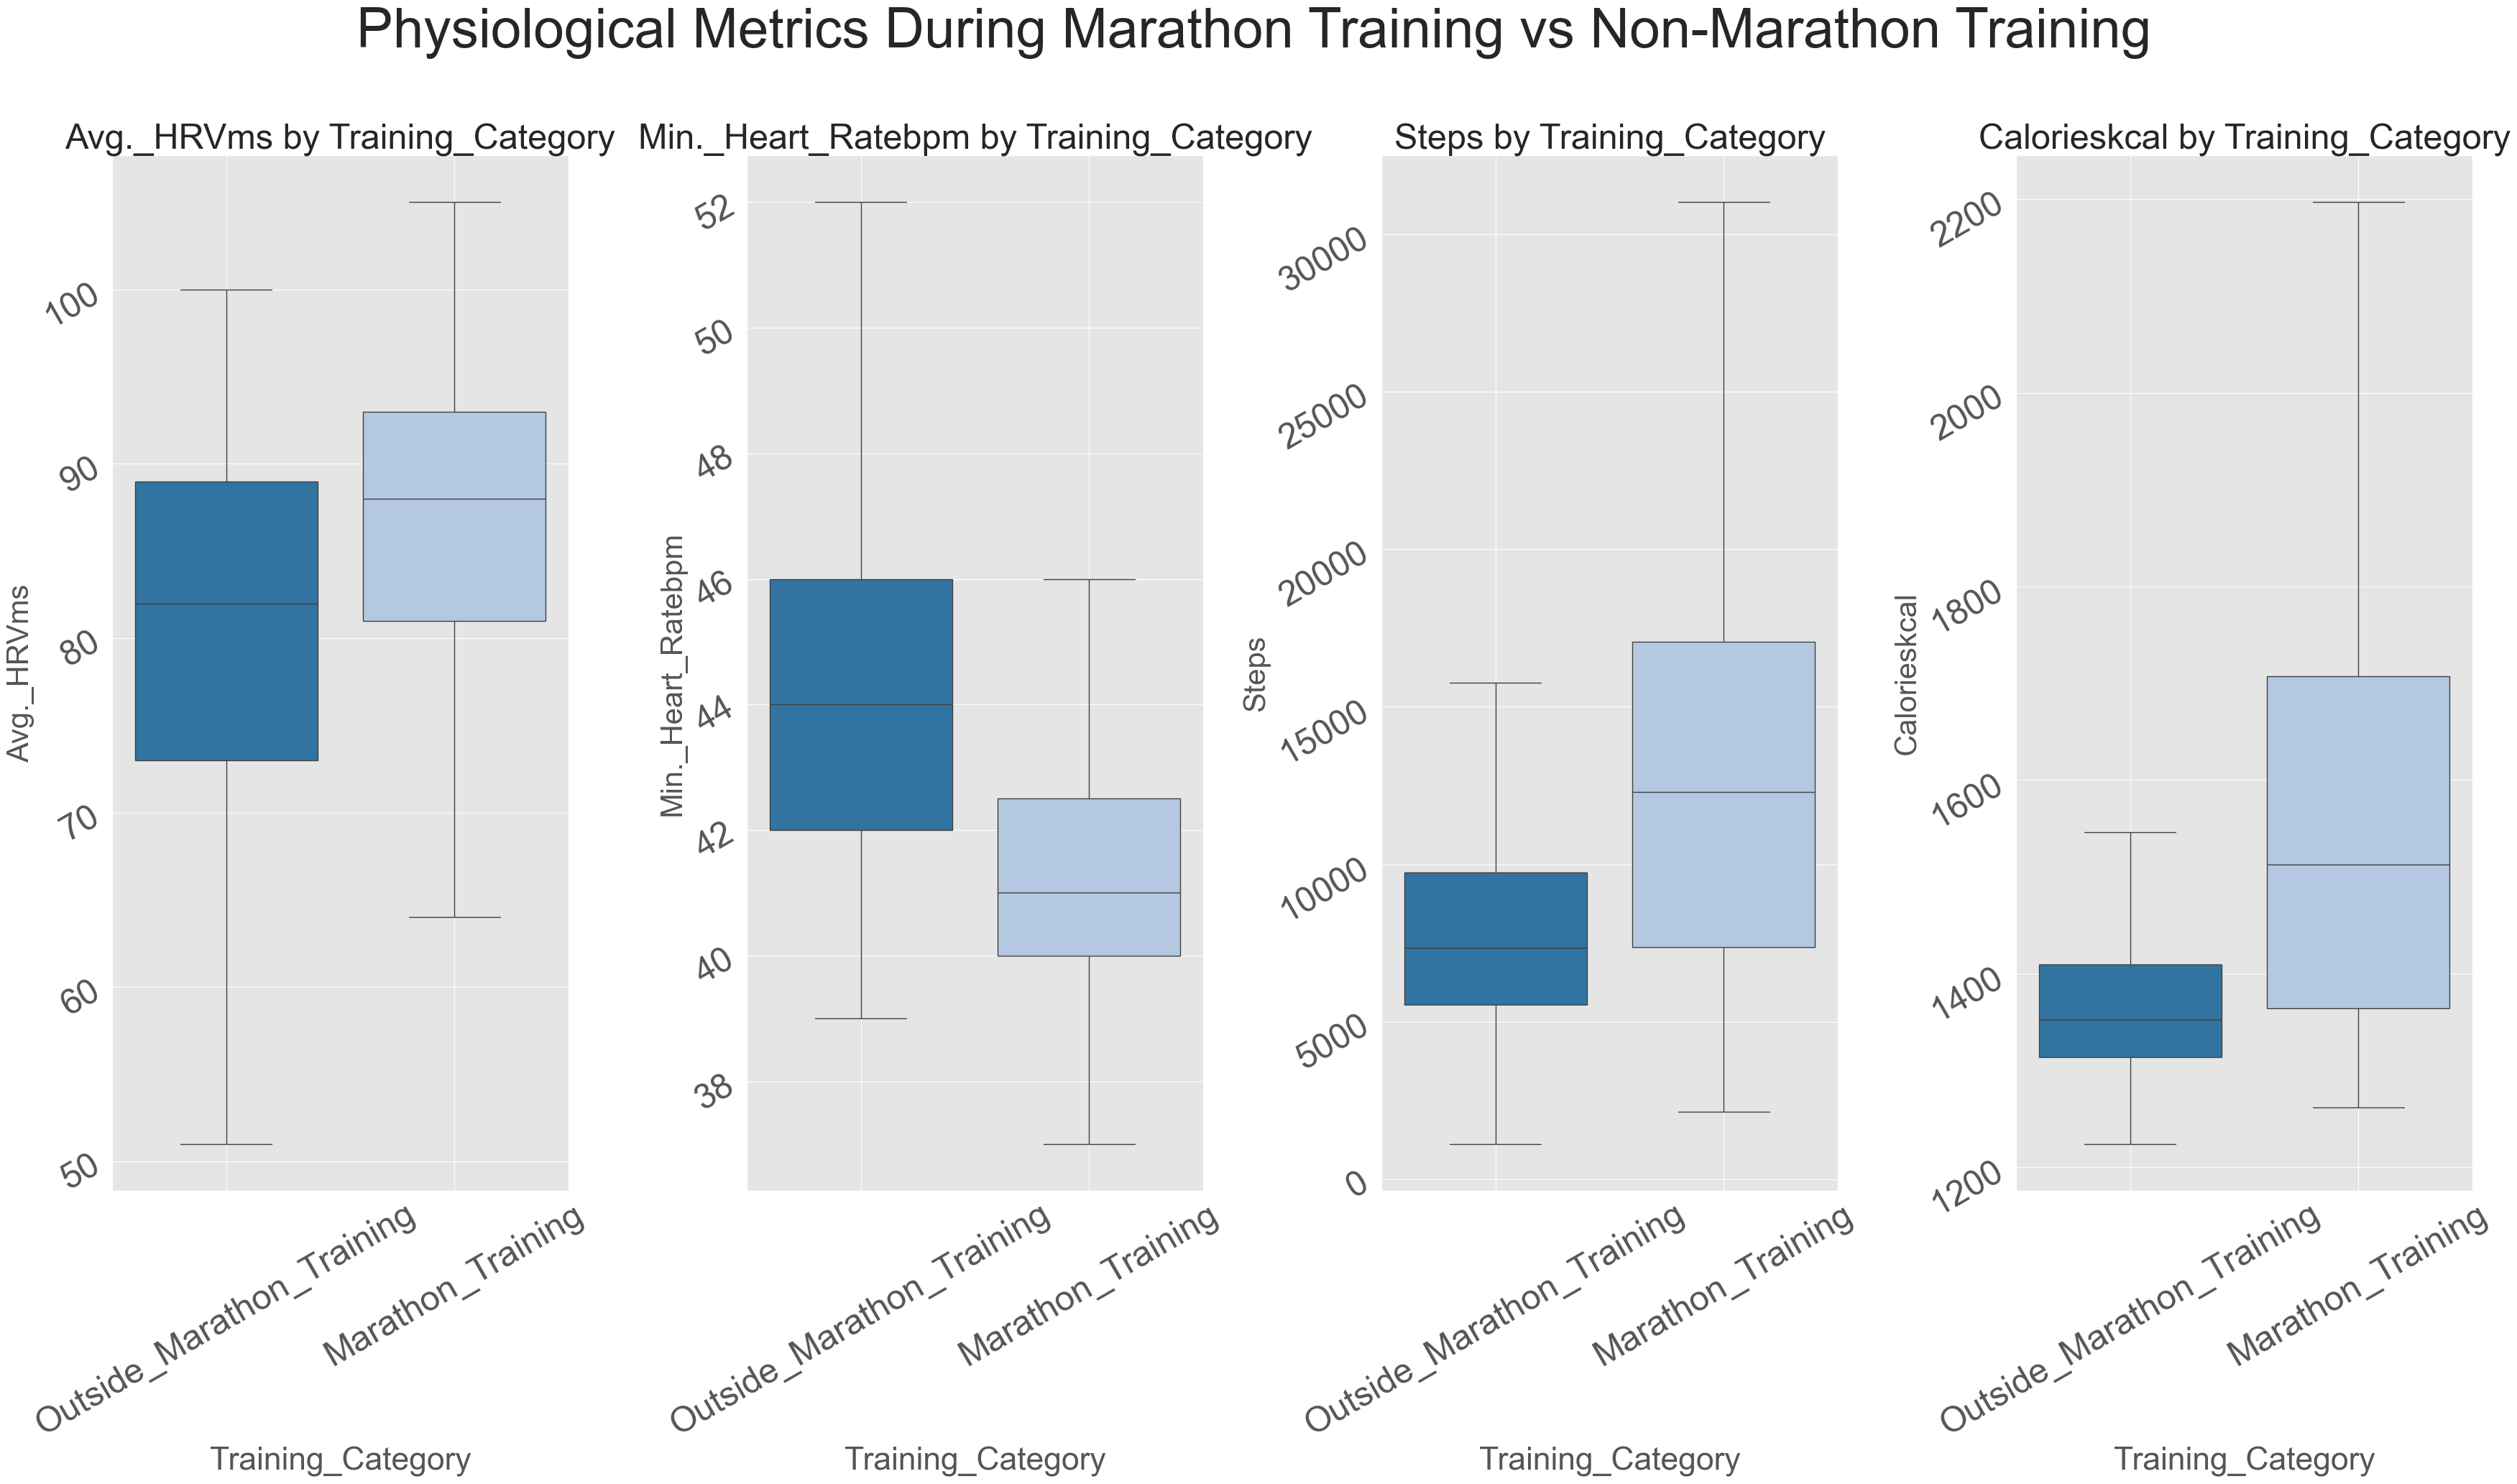

In [267]:
# Define the variables to plot 
variables = [
             "Avg._HRVms", "Min._Heart_Ratebpm", "Steps", "Calorieskcal"]

# Set up figure with subplots arranged in a grid (e.g., 2 rows and 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(35, 20))  
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Set custom color palette with only two colors (one for each group)
custom_palette = sns.color_palette("tab20", n_colors=2)  # Example: 2-color palette

# Loop through variables and create boxplots
for i, var in enumerate(variables):
    sns.boxplot(data=master_df, x="Training_Category", y=var, ax=axes[i], 
                hue="Training_Category", palette=custom_palette, showfliers=False)
    axes[i].set_title(f"{var} by Training_Category", fontsize=35)
    axes[i].tick_params(axis="both", rotation=30, labelsize=35)
    
    # Optional: Add grid for readability
    axes[i].grid(True)
    
    # Set axis labels explicitly with larger font size
    axes[i].set_xlabel("Training_Category", fontsize=32)
    axes[i].set_ylabel(var, fontsize=30)
    

# Add a common title for the entire figure
fig.suptitle("Physiological Metrics During Marathon Training vs Non-Marathon Training", fontsize=55, y=1.03)
sns.set_style("white")

# Adjust the layout for better spacing
plt.tight_layout()

plt.savefig("mar_vs_notmar_physio.png", dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

In [268]:
import numpy as np
from scipy import stats

# Initialize a dictionary to store the results
t_test_results = {}

for var in variables:
    marathon_training_data = master_df[master_df["Training_Category"] == "Marathon_Training"][var].dropna()
    not_marathon_training_data = master_df[master_df["Training_Category"] == "Outside_Marathon_Training"][var].dropna()
    
    mean_marathon = marathon_training_data.mean()
    std_marathon = marathon_training_data.std()
    n_marathon = len(marathon_training_data)
    
    mean_not_marathon = not_marathon_training_data.mean()
    std_not_marathon = not_marathon_training_data.std()
    n_not_marathon = len(not_marathon_training_data)
    
    # Percent increase
    percent_change = ((mean_marathon - mean_not_marathon) / mean_not_marathon) * 100
    
    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(marathon_training_data, not_marathon_training_data, nan_policy='omit')
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(
        ((n_marathon - 1) * std_marathon ** 2 + (n_not_marathon - 1) * std_not_marathon ** 2) /
        (n_marathon + n_not_marathon - 2)
    )
    
    cohen_d = (mean_marathon - mean_not_marathon) / pooled_std
    
    #Cohens d is a standardized difference that measures the effect size between two groups. It representes
    #the difference between the means of two groups in terms of standard deviations, indicating how much the groups differ.
    #A larger Cohen's d suggests a greater effect size 
    
    t_test_results[var] = {
        't-statistic': t_stat,
        'p-value': p_value,
        'mean_marathon': mean_marathon,
        'std_marathon': std_marathon,
        'mean_not_marathon': mean_not_marathon,
        'std_not_marathon': std_not_marathon,
        '% Difference': f"{percent_change:.1f}%",
        "Cohen's d": cohen_d
    }

# Print the results
for var, result in t_test_results.items():
    print(f"{var}:")
    print(f"  T-statistic: {result['t-statistic']:.3f}")
    print(f"  P-value: {result['p-value']:.10f}")
    print("  Significant difference?" , "Yes" if result['p-value'] < 0.05 else "No")
    print(f"  Marathon Training - Mean: {result['mean_marathon']:.2f}, Std: {result['std_marathon']:.2f}")
    print(f"  Outside of Marathon - Mean: {result['mean_not_marathon']:.2f}, Std: {result['std_not_marathon']:.2f}")
    print(f"  % Difference: {result['% Difference']}")
    cohen_d = result["Cohen's d"]
    print(f"  Cohen's d: {cohen_d:.3f}")



Avg._HRVms:
  T-statistic: 4.473
  P-value: 0.0000109534
  Significant difference? Yes
  Marathon Training - Mean: 86.01, Std: 9.85
  Outside of Marathon - Mean: 79.96, Std: 12.12
  % Difference: 7.6%
  Cohen's d: 0.533
Min._Heart_Ratebpm:
  T-statistic: -8.234
  P-value: 0.0000000000
  Significant difference? Yes
  Marathon Training - Mean: 41.48, Std: 2.33
  Outside of Marathon - Mean: 44.14, Std: 2.90
  % Difference: -6.0%
  Cohen's d: -0.982
Steps:
  T-statistic: 7.355
  P-value: 0.0000000000
  Significant difference? Yes
  Marathon Training - Mean: 13684.65, Std: 8664.25
  Outside of Marathon - Mean: 8274.36, Std: 4091.70
  % Difference: 65.4%
  Cohen's d: 0.877
Calorieskcal:
  T-statistic: 8.191
  P-value: 0.0000000000
  Significant difference? Yes
  Marathon Training - Mean: 1568.71, Std: 267.65
  Outside of Marathon - Mean: 1385.13, Std: 120.08
  % Difference: 13.3%
  Cohen's d: 0.977


In [269]:
print(variables)
print(master_df.columns.tolist())


['Avg._HRVms', 'Min._Heart_Ratebpm', 'Steps', 'Calorieskcal']
['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time', 'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio', 'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin', 'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin', 'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm', 'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms', 'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance', 'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort', 'Average_Heart_Rate', 'Weather_Temperature', 'Humidity', 'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed', 'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence', 'Average_Grade_Adjusted_Pace', 'Start_Minutes', 'Prev_Day_Relative_Effort', 'Avg._HRVms_scaled', 'Min._Heart_Ratebpm_scaled', 'Time_Asleepmin_scaled', 'Prev_Day_Relative_Effort_scaled', 'Sleep_Stages__Deep_Sleepmin_scaled', 'Recovery_Score', 'T

In [270]:
for var in variables:
    marathon_data = master_df[master_df["Training_Category"] == "Marathon_Training"][var].dropna()
    non_marathon_data = master_df[master_df["Training_Category"] == "Outside_Marathon_Training"][var].dropna()
    
    print(f"{var}: Marathon n = {len(marathon_data)}, Outside n = {len(non_marathon_data)}")

Avg._HRVms: Marathon n = 111, Outside n = 192
Min._Heart_Ratebpm: Marathon n = 111, Outside n = 192
Steps: Marathon n = 111, Outside n = 192
Calorieskcal: Marathon n = 111, Outside n = 192


In [271]:
print(master_df[variables].dtypes)

Avg._HRVms            float64
Min._Heart_Ratebpm    float64
Steps                 float64
Calorieskcal          float64
dtype: object


In [272]:
sleep_variables = [
    'Sleep_Time_Ratio',
    'Time_Asleepmin',
    'Sleep_Stages__Awakemin',
    'Sleep_Stages__REMmin',
    'Sleep_Stages__Light_Sleepmin',
    'Sleep_Stages__Deep_Sleepmin'
]

master_df['Sleep_Time_Ratio'] = master_df['Sleep_Time_Ratio'].astype(str).str.rstrip('%').astype(float)

In [273]:
# Initialize a dictionary to store the results
t_test_results = {}

for var in sleep_variables:
    marathon_training_data = master_df[master_df["Training_Category"] == "Marathon_Training"][var].dropna()
    not_marathon_training_data = master_df[master_df["Training_Category"] == "Outside_Marathon_Training"][var].dropna()
    
    mean_marathon = marathon_training_data.mean()
    std_marathon = marathon_training_data.std()
    n_marathon = len(marathon_training_data)
    
    mean_not_marathon = not_marathon_training_data.mean()
    std_not_marathon = not_marathon_training_data.std()
    n_not_marathon = len(not_marathon_training_data)
    
    # Percent increase
    percent_change = ((mean_marathon - mean_not_marathon) / mean_not_marathon) * 100
    
    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(marathon_training_data, not_marathon_training_data, nan_policy='omit')
    
    # Pooled standard deviation for Cohen's d
    pooled_std = np.sqrt(
        ((n_marathon - 1) * std_marathon ** 2 + (n_not_marathon - 1) * std_not_marathon ** 2) /
        (n_marathon + n_not_marathon - 2)
    )
    
    cohen_d = (mean_marathon - mean_not_marathon) / pooled_std
    
    #Cohens d is a standardized difference that measures the effect size between two groups. It representes
    #the difference between the means of two groups in terms of standard deviations, indicating how much the groups differ.
    #A larger Cohen's d suggests a greater effect size 
    
    t_test_results[var] = {
        't-statistic': t_stat,
        'p-value': p_value,
        'mean_marathon': mean_marathon,
        'std_marathon': std_marathon,
        'mean_not_marathon': mean_not_marathon,
        'std_not_marathon': std_not_marathon,
        '% Difference': f"{percent_change:.1f}%",
        "Cohen's d": cohen_d
    }

# Print the results
for var, result in t_test_results.items():
    print(f"{var}:")
    print(f"  T-statistic: {result['t-statistic']:.3f}")
    print(f"  P-value: {result['p-value']:.3f}")
    print("  Significant difference?" , "Yes" if result['p-value'] < 0.05 else "No")
    print(f"  Marathon Training - Mean: {result['mean_marathon']:.2f}, Std: {result['std_marathon']:.2f}")
    print(f"  Outside of Marathon - Mean: {result['mean_not_marathon']:.2f}, Std: {result['std_not_marathon']:.2f}")
    print(f"  % Difference: {result['% Difference']}")
    cohen_d = result["Cohen's d"]
    print(f"  Cohen's d: {cohen_d:.3f}")



Sleep_Time_Ratio:
  T-statistic: 1.207
  P-value: 0.229
  Significant difference? No
  Marathon Training - Mean: 88.77, Std: 4.44
  Outside of Marathon - Mean: 88.03, Std: 5.51
  % Difference: 0.8%
  Cohen's d: 0.144
Time_Asleepmin:
  T-statistic: -0.542
  P-value: 0.588
  Significant difference? No
  Marathon Training - Mean: 451.68, Std: 67.34
  Outside of Marathon - Mean: 456.95, Std: 88.71
  % Difference: -1.2%
  Cohen's d: -0.065
Sleep_Stages__Awakemin:
  T-statistic: -1.314
  P-value: 0.190
  Significant difference? No
  Marathon Training - Mean: 24.85, Std: 20.88
  Outside of Marathon - Mean: 29.02, Std: 29.44
  % Difference: -14.4%
  Cohen's d: -0.156
Sleep_Stages__REMmin:
  T-statistic: -0.799
  P-value: 0.425
  Significant difference? No
  Marathon Training - Mean: 85.26, Std: 28.42
  Outside of Marathon - Mean: 88.00, Std: 28.97
  % Difference: -3.1%
  Cohen's d: -0.095
Sleep_Stages__Light_Sleepmin:
  T-statistic: -0.289
  P-value: 0.773
  Significant difference? No
  Marath

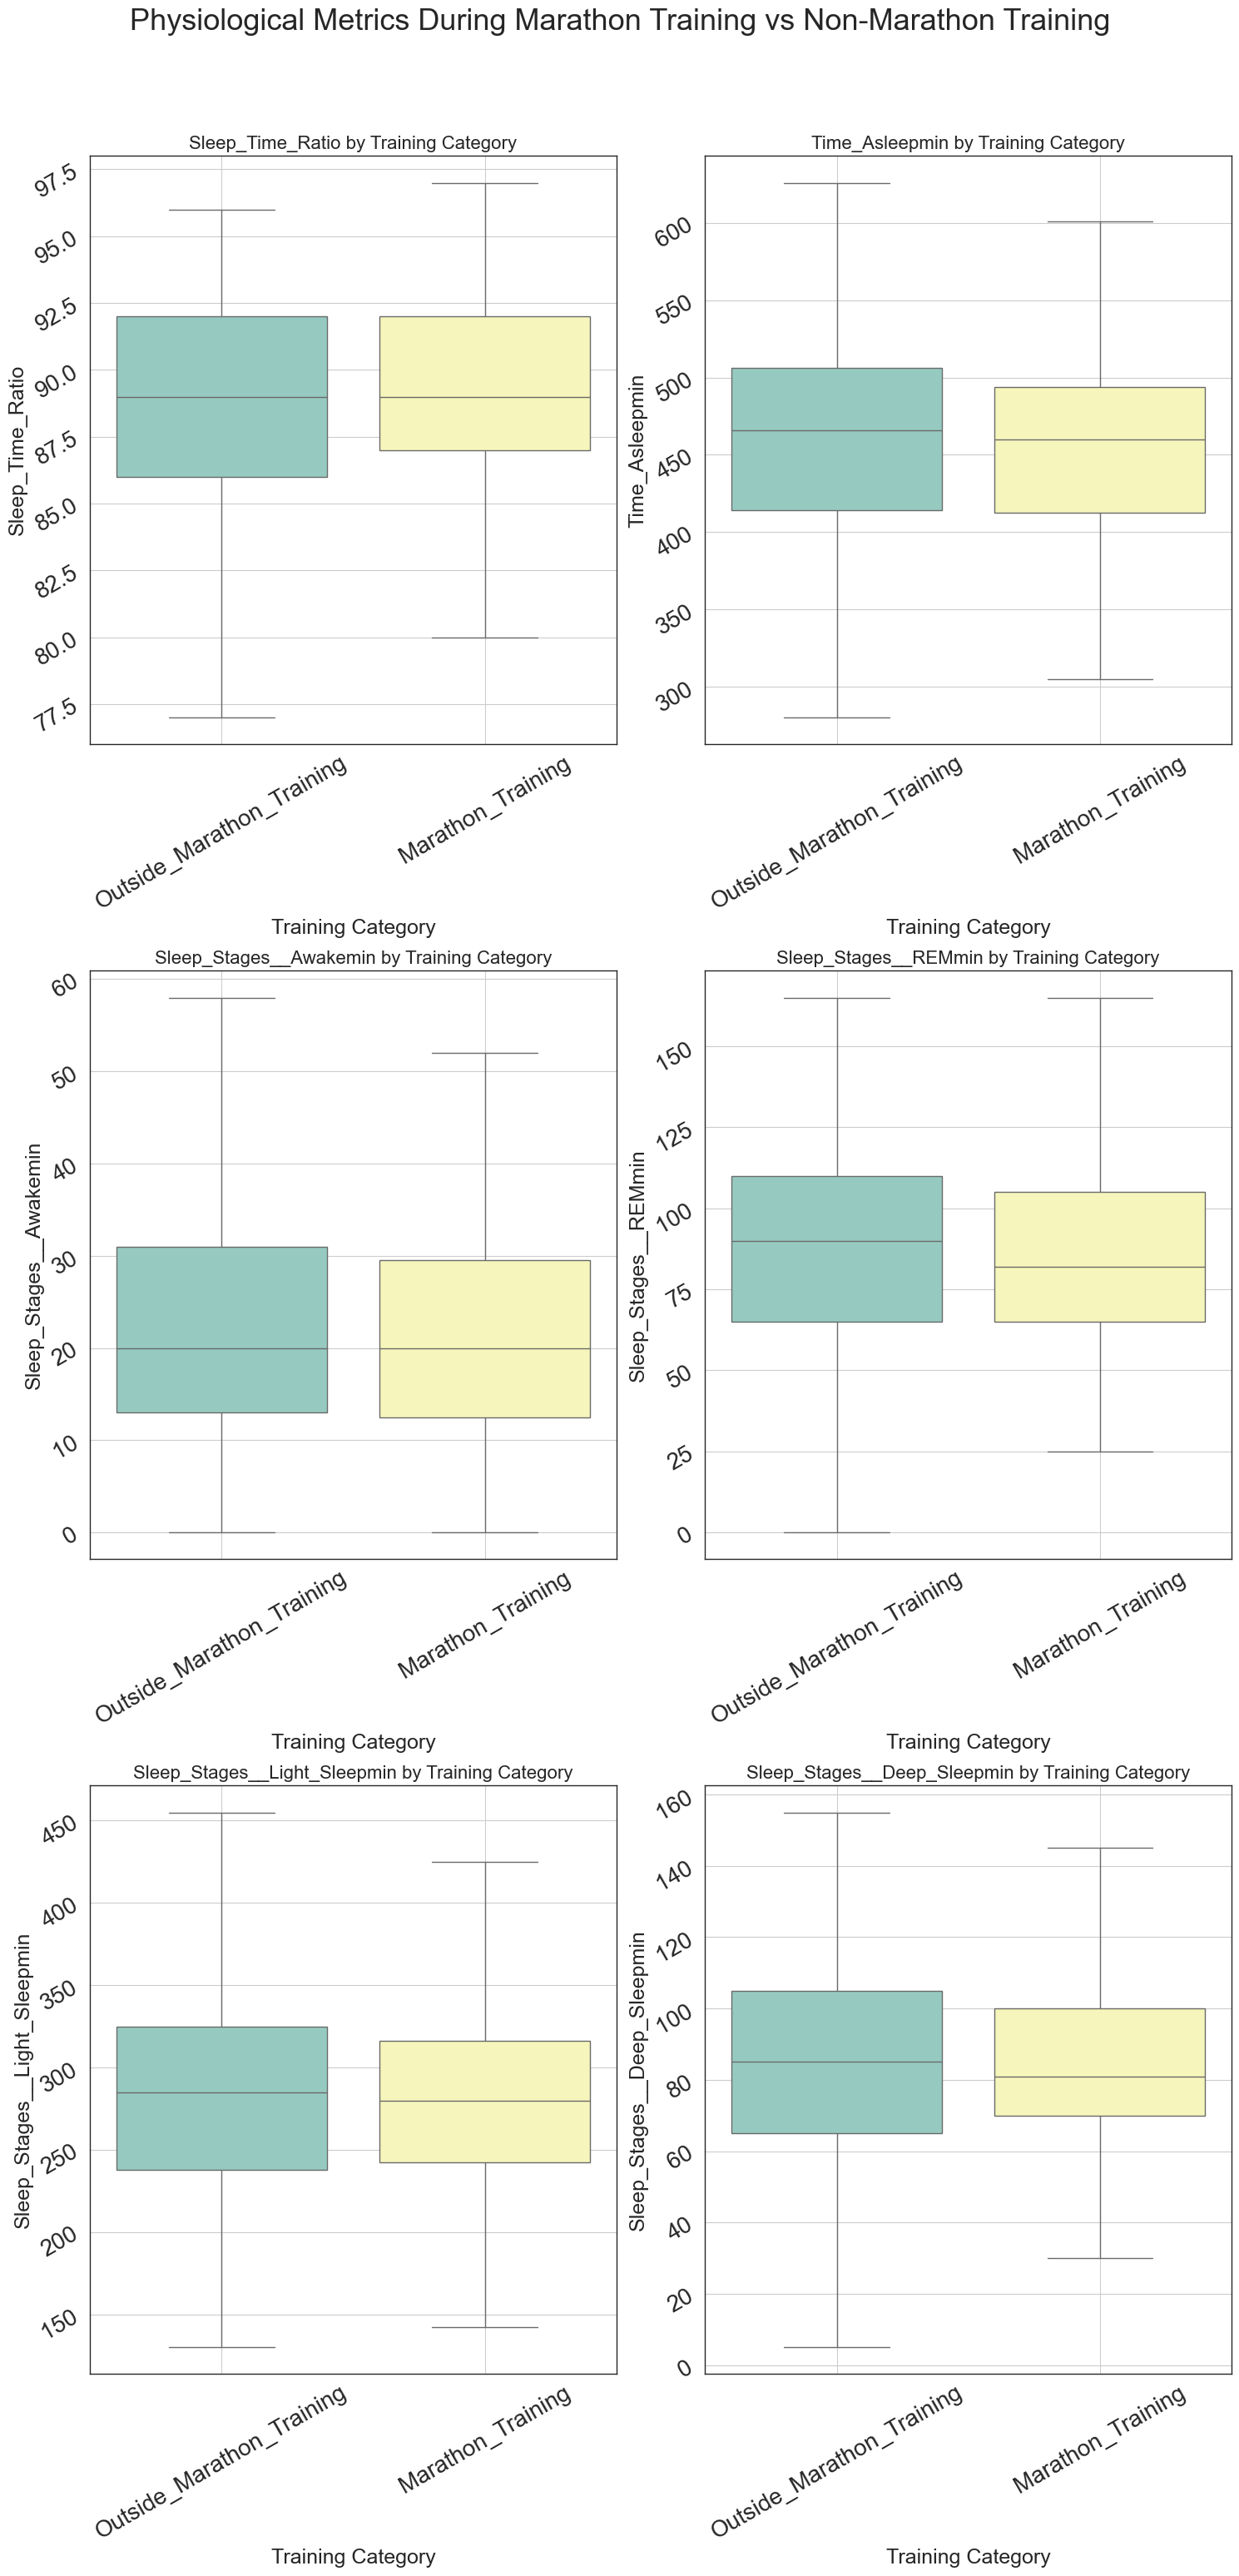

In [274]:
# Set up figure with subplots arranged in a grid (e.g., 2 rows and 3 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 30))  
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Set custom color palette with only two colors (one for each group)
custom_palette = sns.color_palette("Set3", n_colors=2)  # Example: 2-color palette

# Loop through variables and create boxplots
for i, var in enumerate(sleep_variables):
    sns.boxplot(data=master_df, x="Training_Category", y=var, ax=axes[i], 
                hue="Training_Category", palette=custom_palette, showfliers=False)
    axes[i].set_title(f"{var} by Training Category", fontsize=16)
    axes[i].tick_params(axis="both", rotation=30, labelsize=20)
    
    # Optional: Add grid for readability
    axes[i].grid(True)
    
    # Set axis labels explicitly with larger font size
    axes[i].set_xlabel("Training Category", fontsize=18)
    axes[i].set_ylabel(var, fontsize=18)
    

# Add a common title for the entire figure
fig.suptitle("Physiological Metrics During Marathon Training vs Non-Marathon Training", fontsize=26, y=1.03)
sns.set_style("white")

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [275]:
# Columns for each sleep stage (minutes)
sleep_stage_cols = [
    'Sleep_Stages__Awakemin',
    'Sleep_Stages__REMmin',
    'Sleep_Stages__Light_Sleepmin',
    'Sleep_Stages__Deep_Sleepmin'
]

# Create a copy of relevant columns (you can add more if needed)
sleep_df = master_df[['Training_Category', 'Time_Asleepmin', 'Training_Phase'] + sleep_stage_cols].copy()

# Calculate proportion for each stage
for col in sleep_stage_cols:
    sleep_df[col + '_pct'] = (sleep_df[col] / sleep_df['Time_Asleepmin']) * 100

# Preview
print(sleep_df.head())

           Training_Category  Time_Asleepmin Training_Phase  \
1  Outside_Marathon_Training           364.0    PreTraining   
2  Outside_Marathon_Training           505.0    PreTraining   
3  Outside_Marathon_Training           435.0    PreTraining   
4  Outside_Marathon_Training           560.0    PreTraining   
5  Outside_Marathon_Training           557.0    PreTraining   

   Sleep_Stages__Awakemin  Sleep_Stages__REMmin  Sleep_Stages__Light_Sleepmin  \
1                    11.0                 112.0                         197.0   
2                    15.0                  95.0                         335.0   
3                    30.0                 150.0                         200.0   
4                    15.0                  80.0                         375.0   
5                    38.0                  60.0                         362.0   

   Sleep_Stages__Deep_Sleepmin  Sleep_Stages__Awakemin_pct  \
1                         55.0                    3.021978   
2         

In [276]:
# For each row, compute the sum of sleep stages
sleep_df['Total_Sleep_Stages'] = sleep_df[sleep_stage_cols].sum(axis=1)

# Normalize the proportions for each sleep stage
for col in sleep_stage_cols:
    sleep_df[col + '_norm'] = (sleep_df[col] / sleep_df['Total_Sleep_Stages']) * 100

# List of normalized column names
norm_cols = [col + '_norm' for col in sleep_stage_cols]

# Average normalized percentages by 'Training_Category'
sleep_means = sleep_df.groupby('Training_Category')[norm_cols].mean()

# Rename columns to original stage names for clarity
sleep_means.columns = sleep_stage_cols

# Display the result
print(sleep_means)

                           Sleep_Stages__Awakemin  Sleep_Stages__REMmin  \
Training_Category                                                         
Marathon_Training                        4.929707             18.230371   
Outside_Marathon_Training                5.577618             18.576908   

                           Sleep_Stages__Light_Sleepmin  \
Training_Category                                         
Marathon_Training                             58.716420   
Outside_Marathon_Training                     57.979322   

                           Sleep_Stages__Deep_Sleepmin  
Training_Category                                       
Marathon_Training                            18.123502  
Outside_Marathon_Training                    17.866153  


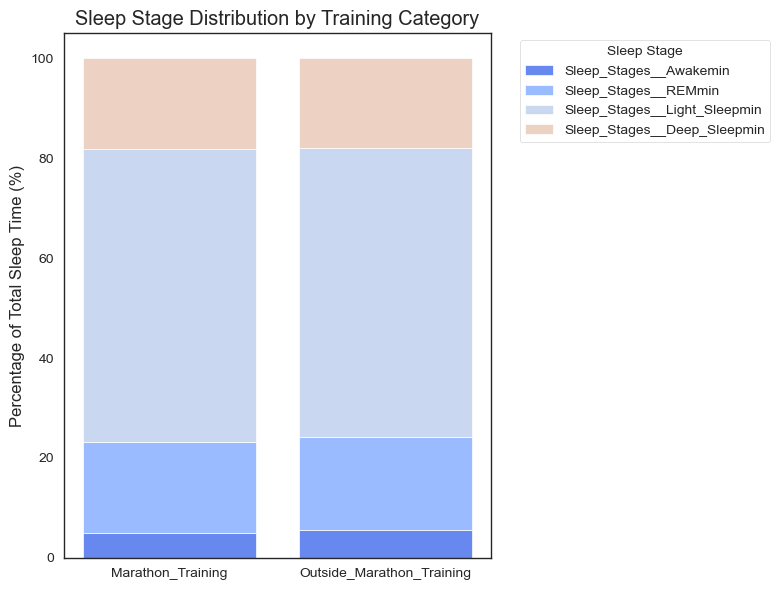

In [277]:
# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8,6))

# Plotting for each sleep stage
bottom = pd.Series([0]*len(sleep_means), index=sleep_means.index)  # to stack bars

for stage in sleep_means.columns:
    ax.bar(sleep_means.index, sleep_means[stage], bottom=bottom, label=stage)
    bottom += sleep_means[stage]

ax.set_ylabel('Percentage of Total Sleep Time (%)')
ax.set_title('Sleep Stage Distribution by Training Category')
ax.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [278]:
# Compute total sleep stages duration per row
sleep_df['Total_Sleep_Stages'] = sleep_df[sleep_stage_cols].sum(axis=1)

# Normalize each sleep stage proportion
for col in sleep_stage_cols:
    sleep_df[col + '_norm'] = (sleep_df[col] / sleep_df['Total_Sleep_Stages']) * 100

# Collect normalized columns
norm_cols = [col + '_norm' for col in sleep_stage_cols]

# Compute average normalized proportions by Training_Phase
sleep_means = sleep_df.groupby('Training_Phase')[norm_cols].mean()

# Rename columns for clarity (remove '_norm' suffix)
sleep_means.columns = sleep_stage_cols

# Display the result
print(sleep_means)

                    Sleep_Stages__Awakemin  Sleep_Stages__REMmin  \
Training_Phase                                                     
Base_Training                     5.145972             18.369162   
Before_PreTraining                3.282828             32.828283   
Build_Phase                       4.989012             17.904534   
Peak_Training                     5.370453             16.355758   
Post_Race                         5.902769             18.623949   
PreTraining                       3.546301             18.376996   
Race                              3.287671             15.068493   
Recovery                          5.059065             17.726900   
Tapering                          3.587840             21.335576   

                    Sleep_Stages__Light_Sleepmin  Sleep_Stages__Deep_Sleepmin  
Training_Phase                                                                 
Base_Training                          59.438911                    17.045955  
Before_PreT

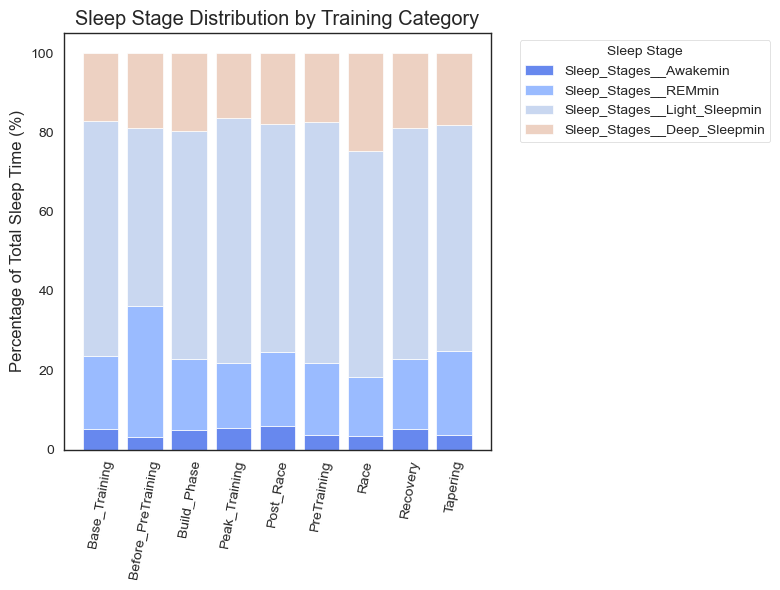

In [279]:
# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8,6))

# Plotting for each sleep stage
bottom = pd.Series([0]*len(sleep_means), index=sleep_means.index)  # to stack bars

for stage in sleep_means.columns:
    ax.bar(sleep_means.index, sleep_means[stage], bottom=bottom, label=stage)
    bottom += sleep_means[stage]

ax.set_ylabel('Percentage of Total Sleep Time (%)')
ax.set_title('Sleep Stage Distribution by Training Category')
ax.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=80)  # or 30, 90, etc.

plt.tight_layout()
plt.show()


## How do my physiological stats differ during different stages of marathon training 


In [280]:
master_df.loc[:, 'cumulative_recovery'] = (
    master_df['Recovery_Score']
    .shift(1)
    .rolling(window=4, min_periods=1)
    
    .sum()
)

In [281]:
marathon_training_data = master_df[master_df["Training_Category"] == "Marathon_Training"]


In [282]:
marathon_training_data.loc[:, 'cumulative_prev_effort'] = (
    master_df['Relative_Effort']
    .shift(1)
    .rolling(window=4, min_periods=1)
    .sum()
)

/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2335001281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marathon_training_data.loc[:, 'cumulative_prev_effort'] = (


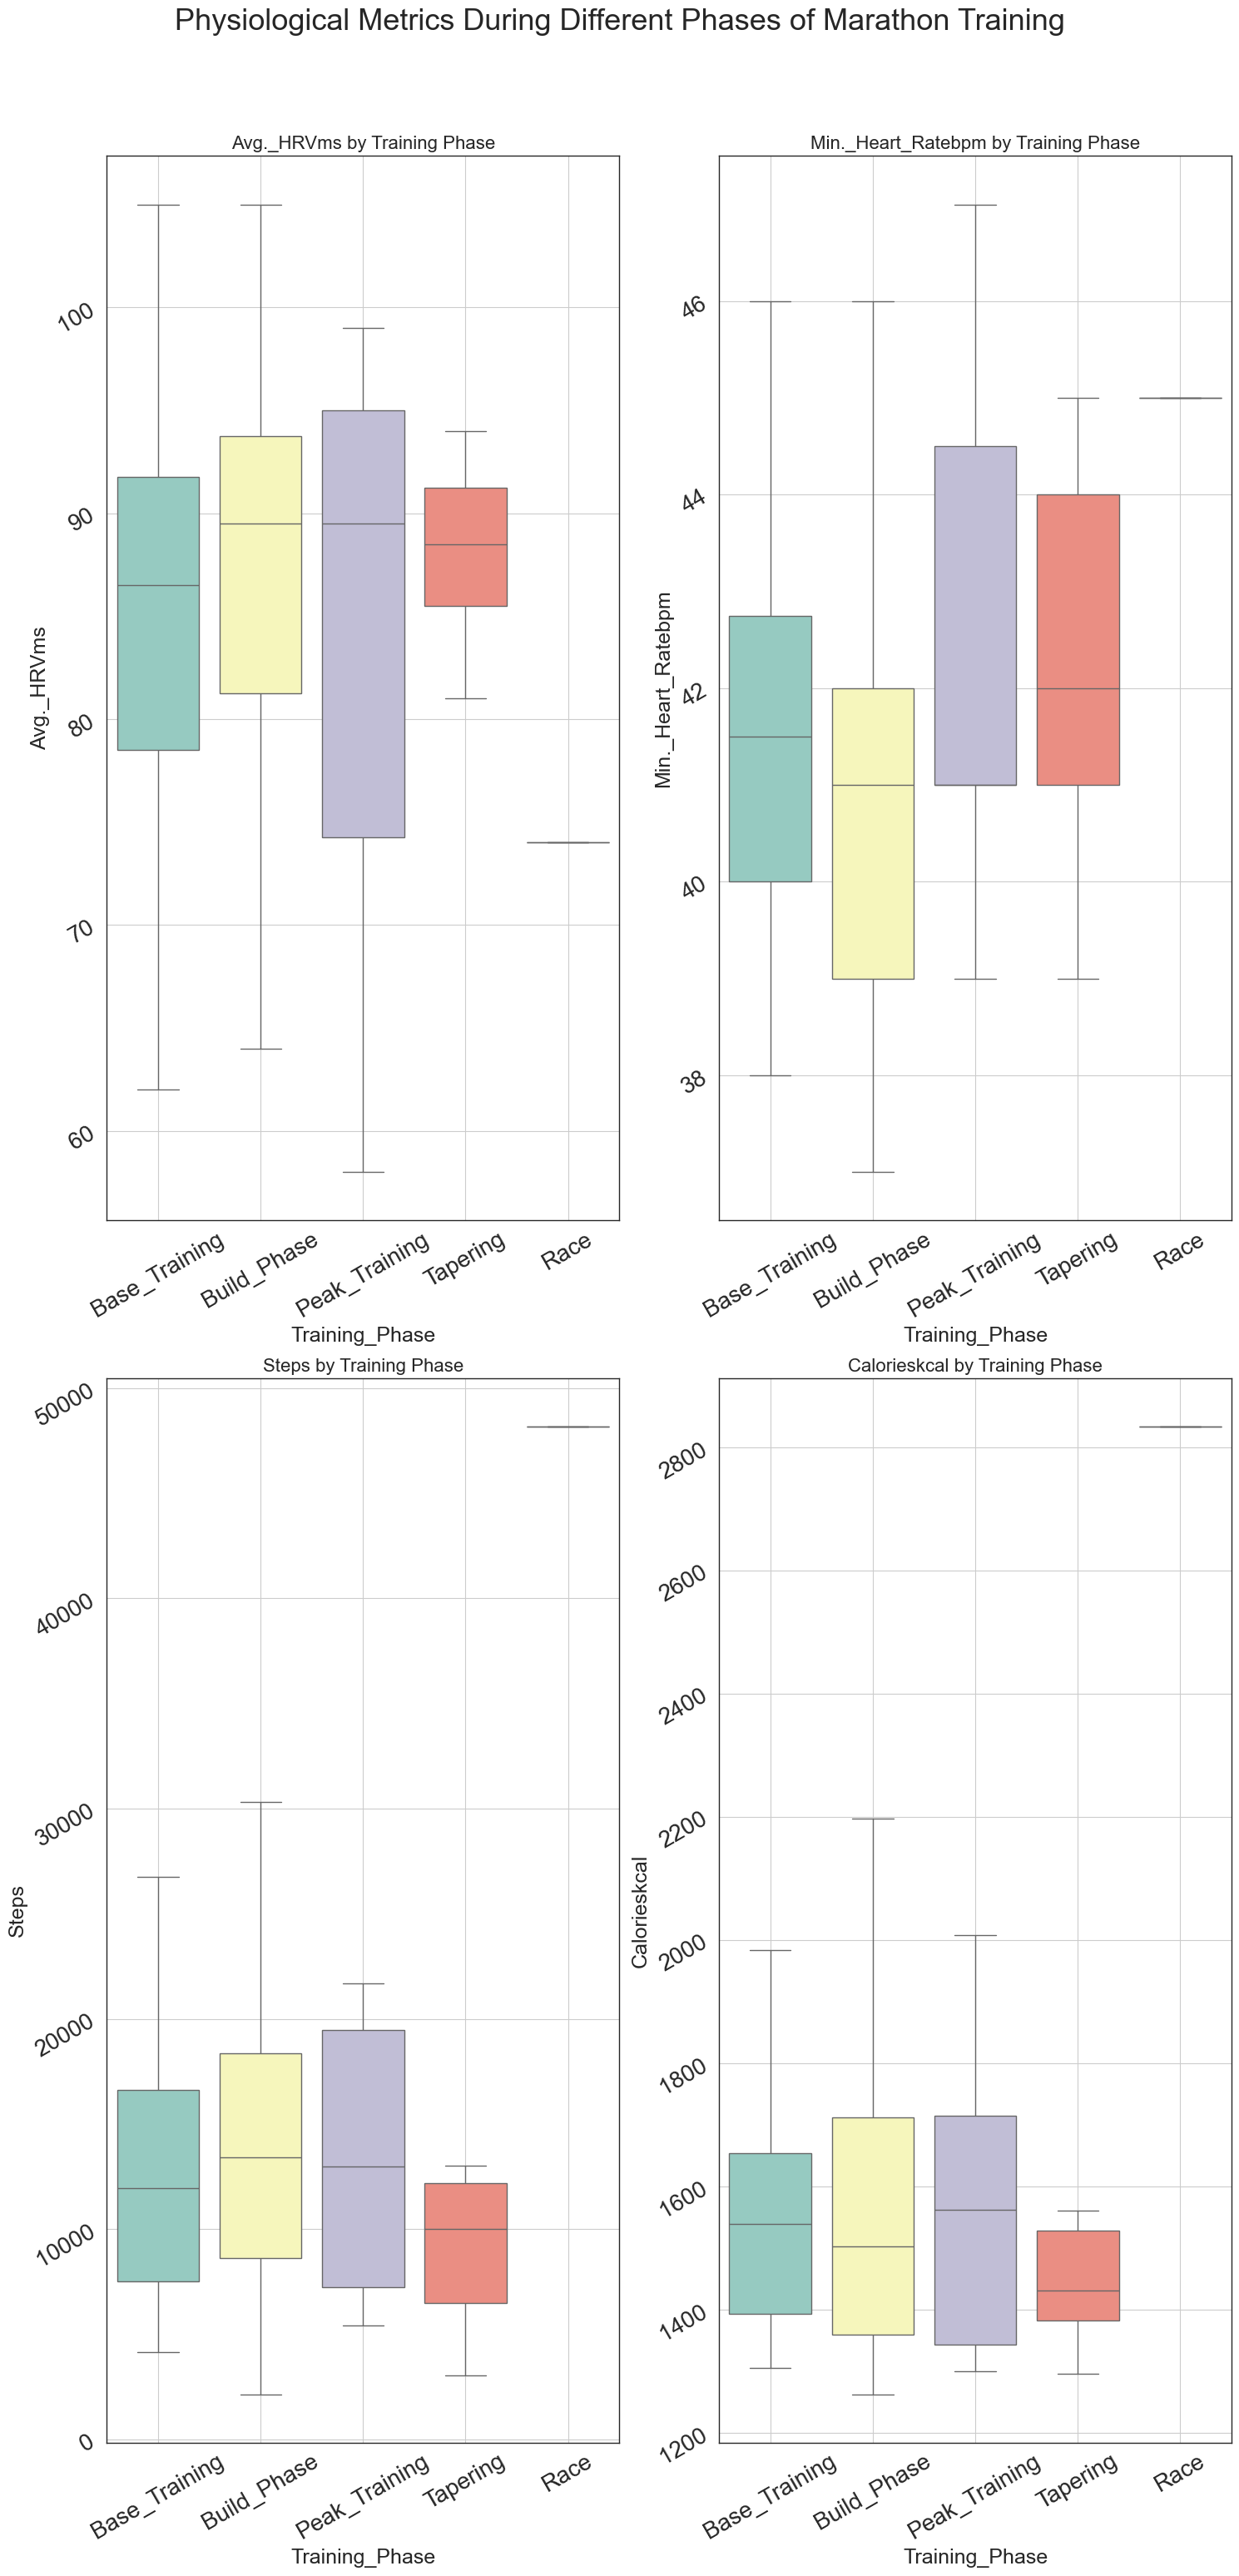

In [285]:
# Set up figure with subplots arranged in a grid (e.g., 2 rows and 3 columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 30))  
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Set custom color palette with only two colors (one for each group)
custom_palette = sns.color_palette("Set3", n_colors=5)  # Example: 2-color palette

# Loop through variables and create boxplots
for i, var in enumerate(variables):
    sns.boxplot(data=marathon_training_data, x="Training_Phase", y=var, ax=axes[i], 
                hue="Training_Phase", palette=custom_palette, showfliers=False)
    axes[i].set_title(f"{var} by Training Phase", fontsize=16)
    axes[i].tick_params(axis="both", rotation=30, labelsize=20)
    
    # Optional: Add grid for readability
    axes[i].grid(True)
    
    # Set axis labels explicitly with larger font size
    axes[i].set_xlabel("Training_Phase", fontsize=18)
    axes[i].set_ylabel(var, fontsize=18)
    

# Add a common title for the entire figure
fig.suptitle("Physiological Metrics During Different Phases of Marathon Training", fontsize=26, y=1.03)

# Adjust the layout for better spacing
plt.tight_layout()
sns.set_style("white")
plt.savefig("phases.png", dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

In [286]:
print(marathon_training_data[marathon_training_data["Training_Phase"] == "Peak_Training"]["Min._Heart_Ratebpm"].mean())

42.214285714285715


Overall, my RHR decreases gradually decreased and stabilized vs peak training which is a good sign that my body was recovering. My average HRV increased steadily during the taper, which is another positive sign that my taper was productive.

## Summary Stats

In [287]:
total_runs=(marathon_training_data[marathon_training_data["Activity_Type"]=='Run'])

#print(f"Total runs: {total_runs}")

category_counts=total_runs["Training_Phase"].value_counts()
print("Runs per category:")
print(category_counts)

cat_avg_dis=total_runs.groupby("Training_Phase")['Distance'].mean()
print("Average distance per category:")
print(cat_avg_dis)

cat_avg_RE=total_runs.groupby("Training_Phase")['Relative_Effort'].mean()
print("Average Relative Effort per category:")
print(cat_avg_RE)

Runs per category:
Training_Phase
Base_Training    23
Build_Phase      22
Peak_Training     7
Tapering          5
Race              1
Name: count, dtype: int64
Average distance per category:
Training_Phase
Base_Training     5.175652
Build_Phase       7.240909
Peak_Training     8.364286
Race             26.360000
Tapering          2.808000
Name: Distance, dtype: float64
Average Relative Effort per category:
Training_Phase
Base_Training     57.565217
Build_Phase       64.272727
Peak_Training     43.142857
Race             343.000000
Tapering          18.400000
Name: Relative_Effort, dtype: float64


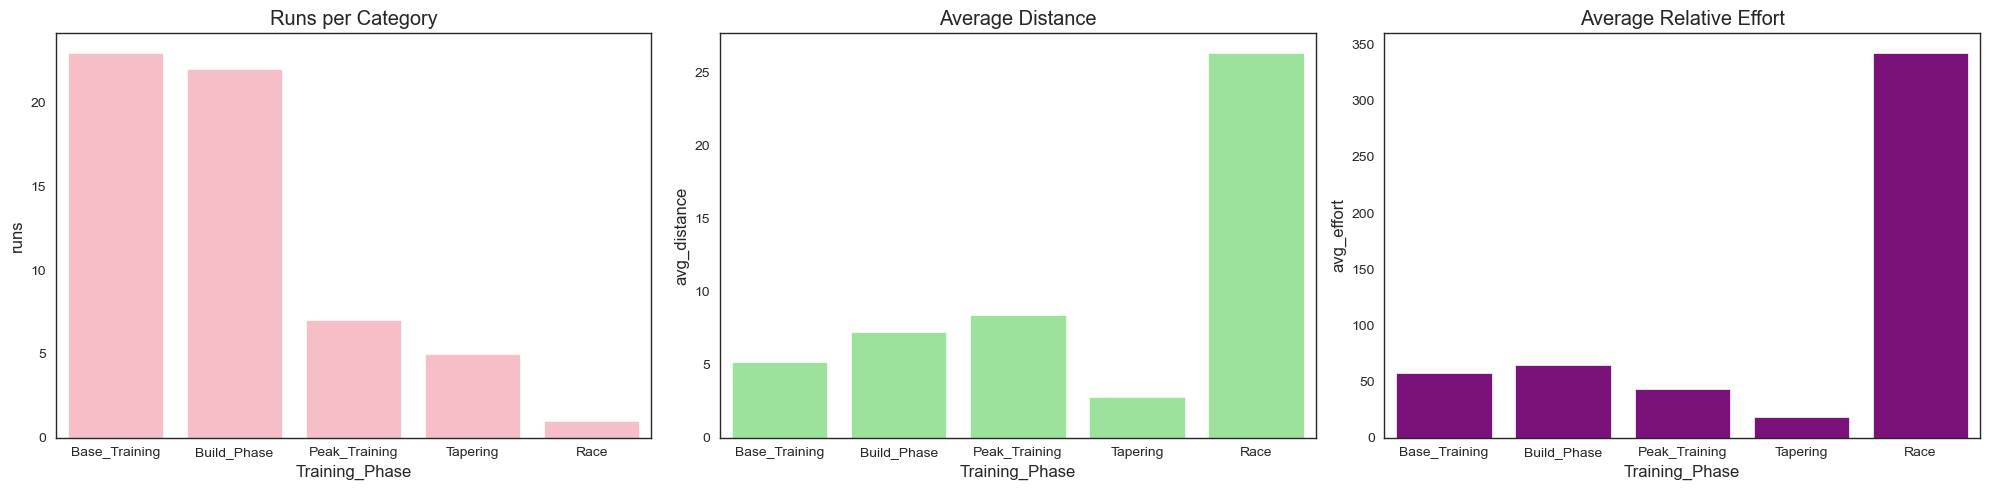

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

summary = total_runs.groupby("Training_Phase").agg(
    runs=("Distance", "count"),
    avg_distance=("Distance", "mean"),
    avg_effort=("Relative_Effort", "mean")
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20,5))



sns.barplot(data=summary, x="Training_Phase", y="runs", ax=axes[0], color="lightpink", order=["Base_Training", "Build_Phase", "Peak_Training", "Tapering", "Race"])
axes[0].set_title("Runs per Category")

sns.barplot(data=summary, x="Training_Phase", y="avg_distance", ax=axes[1], color="lightgreen", order=["Base_Training", "Build_Phase", "Peak_Training", "Tapering", "Race"])
axes[1].set_title("Average Distance")

sns.barplot(data=summary, x="Training_Phase", y="avg_effort", ax=axes[2], color="darkmagenta", order=["Base_Training", "Build_Phase", "Peak_Training", "Tapering", "Race"])
axes[2].set_title("Average Relative Effort")

plt.tight_layout()
plt.savefig("run_summary.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/3154274420.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=total_runs, x='Training_Phase', y='Distance', palette='pastel')


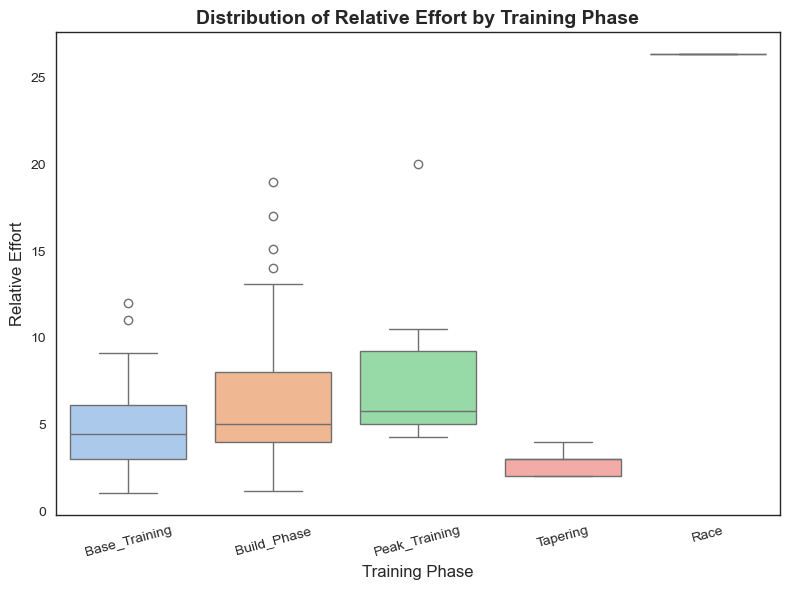

In [289]:
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=total_runs, x='Training_Phase', y='Distance', palette='pastel')

# Customize the plot
plt.title("Distribution of Relative Effort by Training Phase", fontsize=14, weight='bold')
plt.xlabel("Training Phase", fontsize=12)
plt.ylabel("Relative Effort", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [290]:
print(total_runs[total_runs["Training_Phase"]=="Race"])

          Date    Steps  Calorieskcal         Start_Time_x  \
131 2024-09-08  48172.0        2834.0  2024-09-07 23:11:25   

               End_Time  Falling_Asleep_Time          Wakeup_time  \
131 2024-09-08 05:28:55  2024-09-07 23:21:25  2024-09-08 05:26:25   

     Sleep_Time_Ratio  Time_Asleepmin  Sleep_Stages__Awakemin  ...  \
131              93.0           353.0                    12.0  ...   

     Avg._HRVms_scaled  Min._Heart_Ratebpm_scaled  Time_Asleepmin_scaled  \
131           0.507937                   0.533333               0.457704   

     Prev_Day_Relative_Effort_scaled  Sleep_Stages__Deep_Sleepmin_scaled  \
131                         0.090379                            0.548387   

     Recovery_Score Training_Phase  Training_Category cumulative_recovery  \
131       55.846791           Race  Marathon_Training          288.342024   

     cumulative_prev_effort  
131                    51.0  

[1 rows x 52 columns]


In [294]:
print(summary_df.head())

  Training_Phase  Run_Count  Average_Distance
0            NaN         23          5.175652
1            NaN         22          7.240909
2            NaN          7          8.364286
3            NaN          1         26.360000
4            NaN          5          2.808000


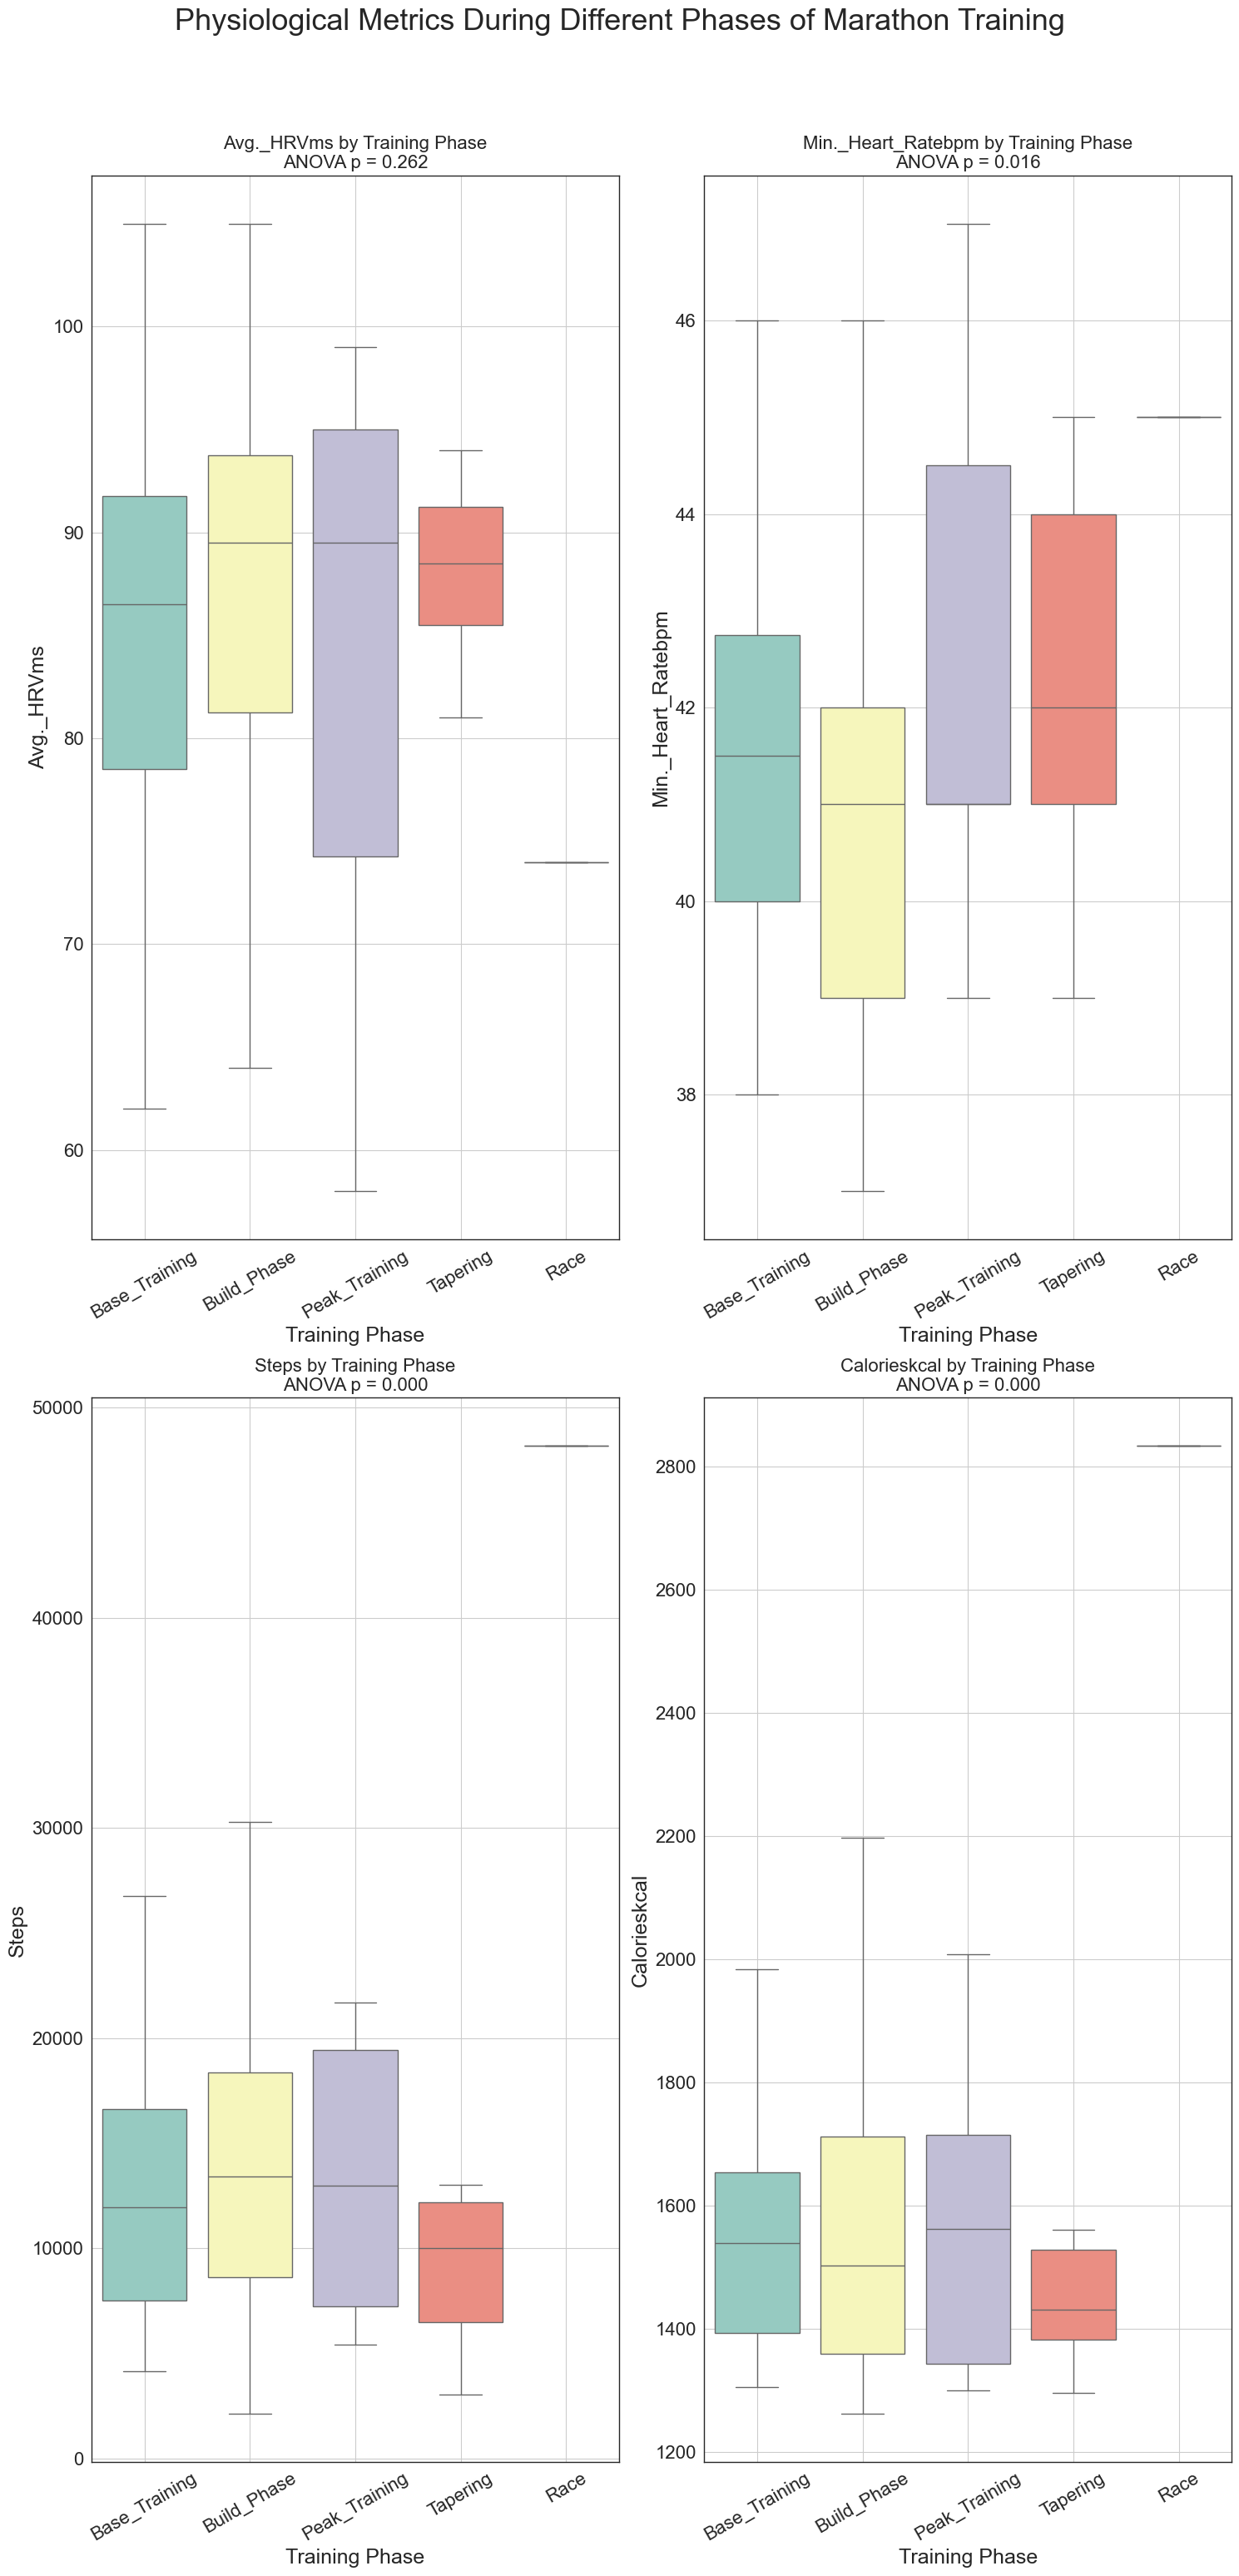

In [297]:
from scipy.stats import f_oneway

# Set up figure with subplots arranged in a grid
fig, axes = plt.subplots(2, 2, figsize=(15, 30))  
axes = axes.flatten()

# Set custom color palette for the phases
custom_palette = sns.color_palette("Set3", n_colors=5)

# Loop through variables and create boxplots with ANOVA
for i, var in enumerate(variables):
    sns.boxplot(data=marathon_training_data, x="Training_Phase", y=var, ax=axes[i], 
                hue="Training_Phase", palette=custom_palette, showfliers=False)
    
    # Run one-way ANOVA
    phase_groups = [group[var].dropna() for name, group in marathon_training_data.groupby("Training_Phase")]
    f_stat, p_value = f_oneway(*phase_groups)
    
    # Title includes ANOVA p-value
    axes[i].set_title(f"{var} by Training Phase\nANOVA p = {p_value:.3f}", fontsize=16)
    
    # Rotate x-axis labels and increase font sizes
    axes[i].tick_params(axis="x", rotation=30, labelsize=16)
    axes[i].tick_params(axis="y", labelsize=16)
    
    # Axis labels
    axes[i].set_xlabel("Training Phase", fontsize=18)
    axes[i].set_ylabel(var, fontsize=18)
    
    # Optional: gridlines
    axes[i].grid(True)

# Overall figure title
fig.suptitle("Physiological Metrics During Different Phases of Marathon Training", fontsize=26, y=1.03)

plt.tight_layout()
plt.show()

In [298]:
# Filter out the 'Race' phase
filtered_marathon = marathon_training_data[marathon_training_data["Training_Phase"] != "Race"]



In [299]:
marathon_training_data["Distance"].sum()

377.28999999999996

In [300]:
marathon_training_data.columns

Index(['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time',
       'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio',
       'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin',
       'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin',
       'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm',
       'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms',
       'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance',
       'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort',
       'Average_Heart_Rate', 'Weather_Temperature', 'Humidity',
       'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed',
       'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence',
       'Average_Grade_Adjusted_Pace', 'Start_Minutes',
       'Prev_Day_Relative_Effort', 'Avg._HRVms_scaled',
       'Min._Heart_Ratebpm_scaled', 'Time_Asleepmin_scaled',
       'Prev_Day_Relative_Effort_scaled', 'Sleep_Stages__D

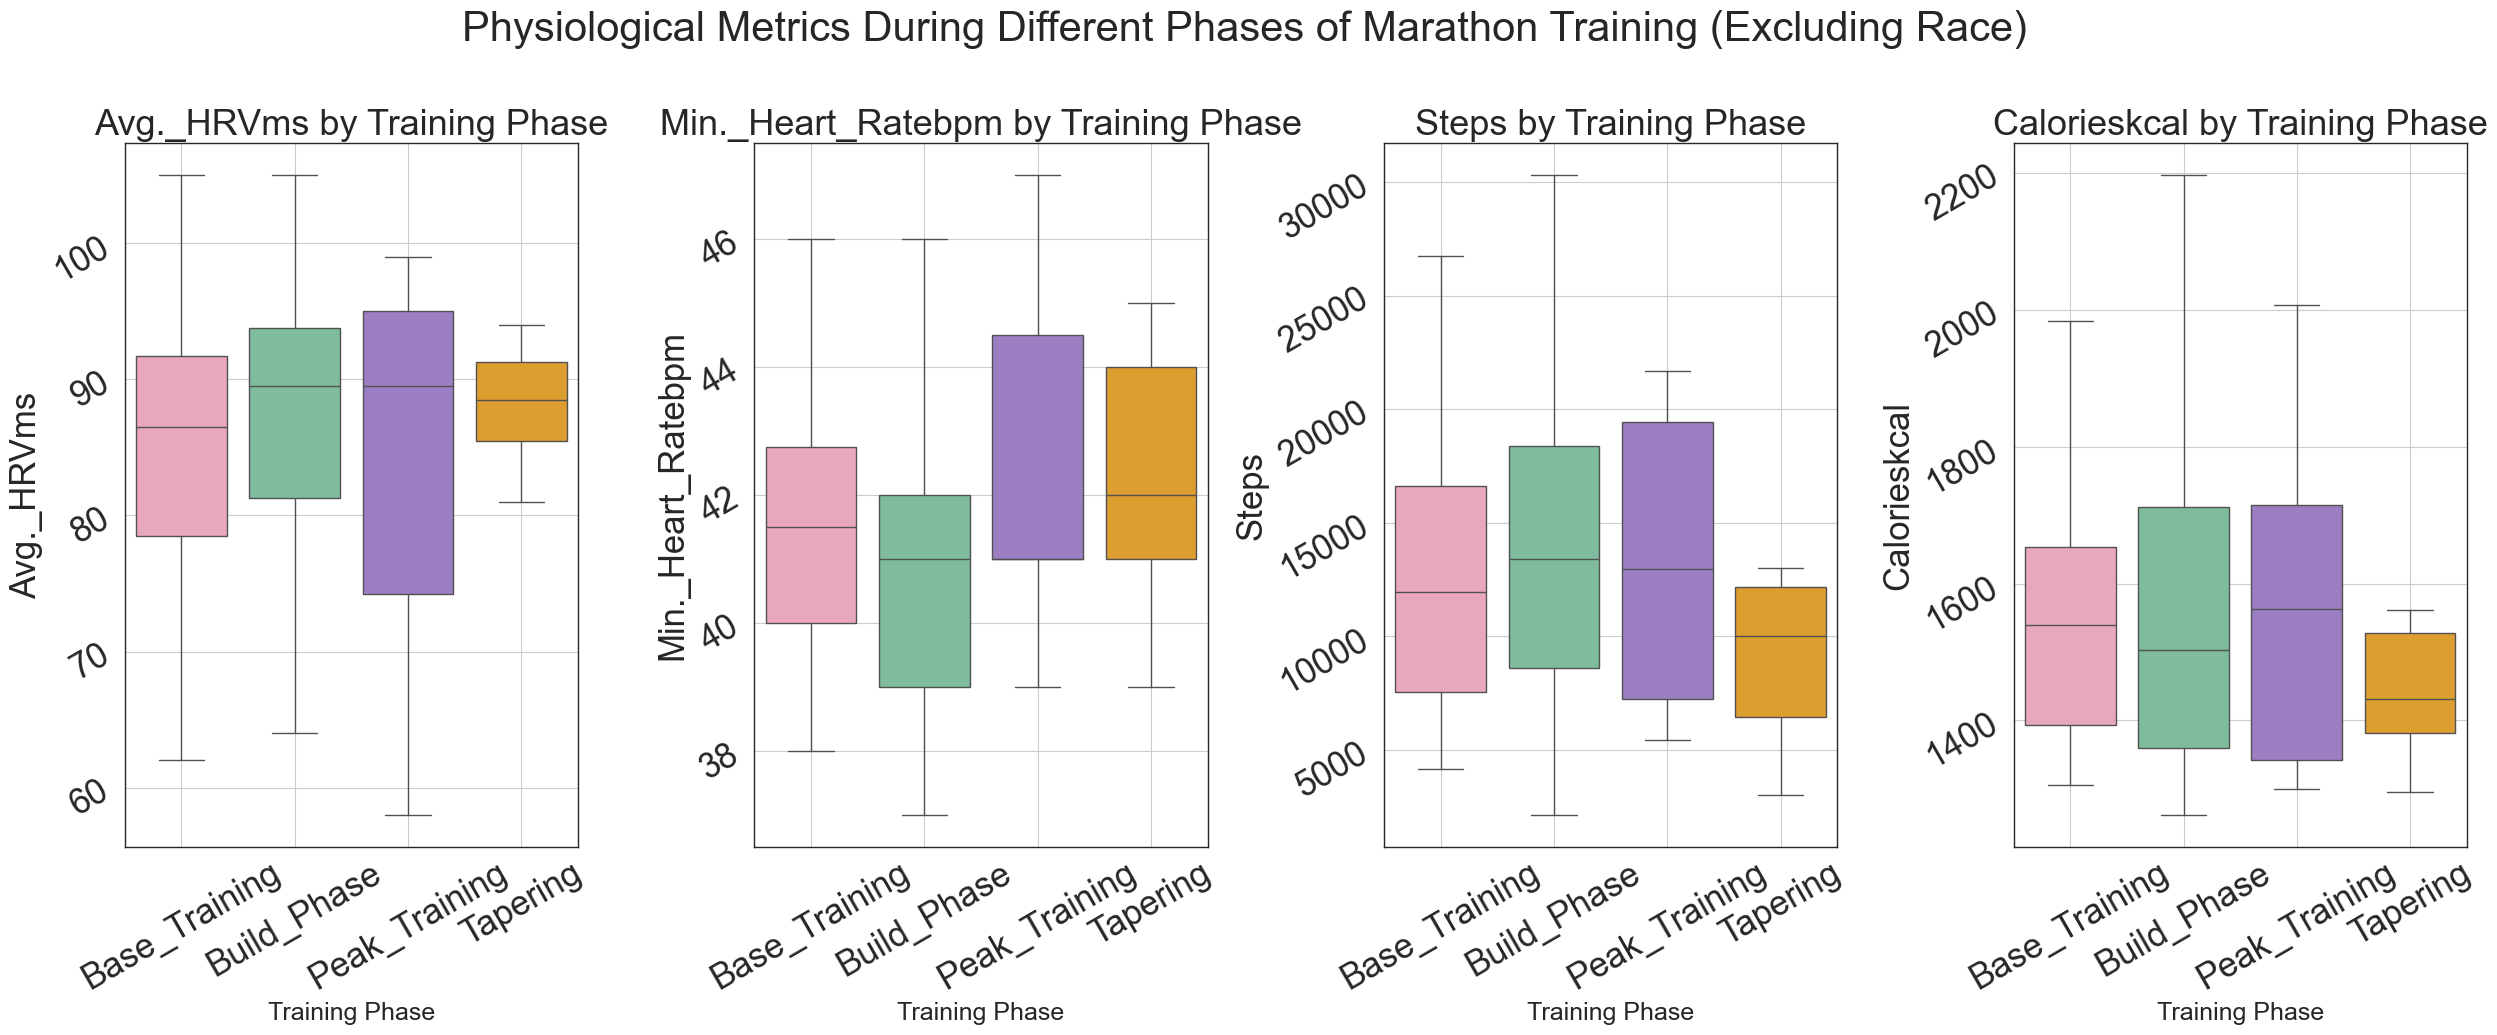

In [301]:
fig, axes = plt.subplots(1, 4, figsize=(25, 10))  
axes = axes.flatten()

custom_palette = ["#f49cbb", "#74c69d", "#9b72cf", "#faa613"]  # pink, coral, green, dark green
palette = sns.color_palette(custom_palette, n_colors=marathon_training_data["Training_Phase"].nunique())

for i, var in enumerate(variables):
    sns.boxplot(
        data=filtered_marathon, 
        x="Training_Phase", 
        y=var, 
        ax=axes[i], 
        hue="Training_Phase", 
        palette=custom_palette, 
        showfliers=False)
    
    axes[i].set_title(f"{var} by Training Phase", fontsize=26)
    axes[i].tick_params(axis="both", rotation=30, labelsize=25)
    axes[i].grid(True)
    axes[i].set_xlabel("Training Phase", fontsize=18)
    axes[i].set_ylabel(var, fontsize=25)

fig.suptitle(
    "Physiological Metrics During Different Phases of Marathon Training (Excluding Race)", 
    fontsize=30, 
    y=1.03)

plt.tight_layout()
plt.savefig("all_phases_phys.png", dpi=300, bbox_inches='tight')

plt.show()

In [302]:
means = filtered_marathon.groupby("Training_Phase")[variables].mean()
print(means)

                Avg._HRVms  Min._Heart_Ratebpm         Steps  Calorieskcal
Training_Phase                                                            
Base_Training    84.309524           41.809524  12570.380952   1559.142857
Build_Phase      87.690476           40.595238  15042.571429   1578.285714
Peak_Training    84.500000           42.214286  14462.785714   1572.357143
Tapering         88.833333           42.250000   9050.083333   1459.000000


In [303]:
median = filtered_marathon.groupby("Training_Phase")[variables].median()
print(median)

                Avg._HRVms  Min._Heart_Ratebpm    Steps  Calorieskcal
Training_Phase                                                       
Base_Training         86.5                41.5  11946.0        1539.0
Build_Phase           89.5                41.0  13392.5        1503.0
Peak_Training         89.5                41.0  12961.5        1562.5
Tapering              88.5                42.0  10018.5        1431.0


In [304]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from patsy import dmatrix

for var in variables:
    try:
        # Surround variable name with Q() to handle special characters
        model = ols(f'Q("{var}") ~ C(Training_Phase)', data=filtered_marathon).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        F = anova_table['F'][0]
        p = anova_table['PR(>F)'][0]
        print(f"{var}: F = {F:.2f}, p = {p:.3f}")
    except Exception as e:
        print(f"Error processing {var}: {e}")

Avg._HRVms: F = 1.27, p = 0.287
Min._Heart_Ratebpm: F = 3.43, p = 0.020
Steps: F = 2.04, p = 0.113
Calorieskcal: F = 0.79, p = 0.500


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2758864352.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F = anova_table['F'][0]
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2758864352.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = anova_table['PR(>F)'][0]
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2758864352.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

The average HRV between groups, the difference in steps between groups, and the calories burned between groups is NOT statistically significant. However, the Min HR (bpm), also known as resting HR is statistically significant which means that at least one group differs in resting heart rate from the others. 

## Ensure you peak at the right time - 
Investigate if there is a downward trend before tapering? Do you peak at the right time? 

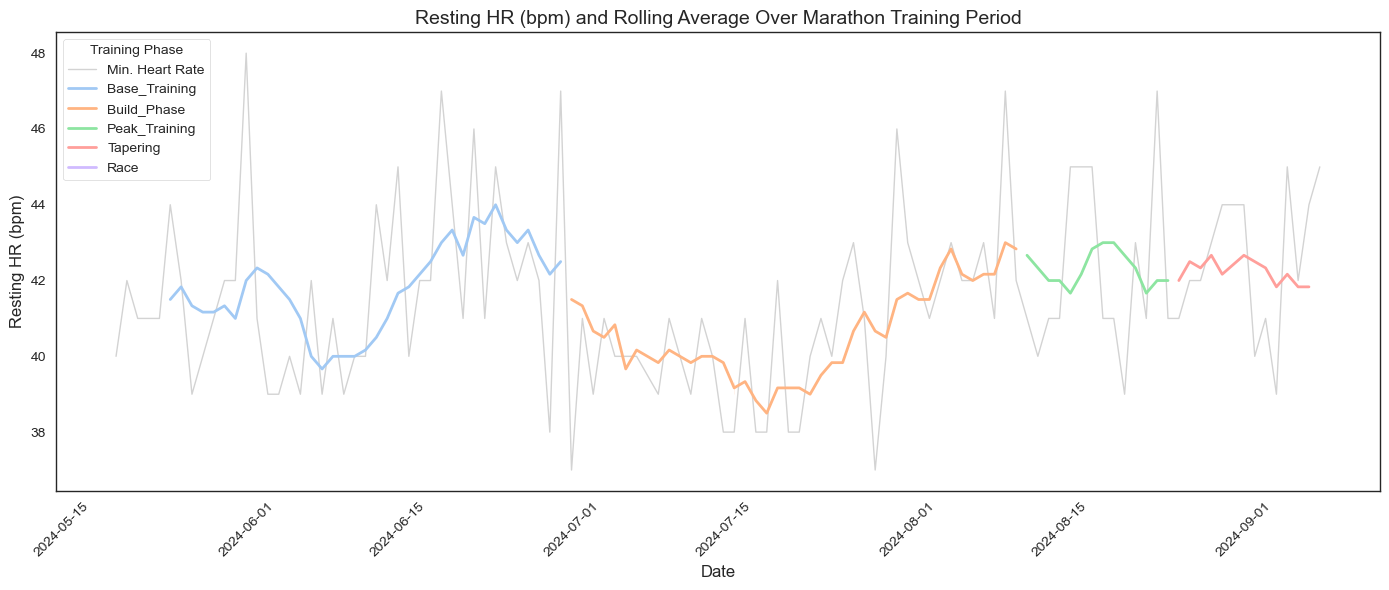

In [305]:
# Filter the data for the Marathon Training period
marathon_training_data = master_df[master_df["Training_Category"] == "Marathon_Training"].copy()

# Set a window size for the rolling average 
window_size = 6

# Apply rolling average to Min._Heart_Ratebpm
marathon_training_data['RollingMinHR'] = marathon_training_data['Min._Heart_Ratebpm'].rolling(window=window_size).mean()

# Define a color palette for different training phases
palette = sns.color_palette("pastel", n_colors=marathon_training_data["Training_Phase"].nunique())

plt.figure(figsize=(14, 6))

# Plot the original Min. Heart Rate in light gray
sns.lineplot(data=marathon_training_data, x='Date', y='Min._Heart_Ratebpm', color='lightgray', label='Min. Heart Rate', linewidth=1)

# Plot the Rolling Average with colors mapped to 'Training_Phase'
sns.lineplot(data=marathon_training_data, x='Date', y='RollingMinHR', hue='Training_Phase', palette=palette, linewidth=2)

# Add labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Resting HR (bpm)", fontsize=12)
plt.title("Resting HR (bpm) and Rolling Average Over Marathon Training Period", fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(title="Training Phase")

# Display the plot
plt.tight_layout()

plt.savefig("restingHR.png", dpi=300, bbox_inches='tight')

plt.show()

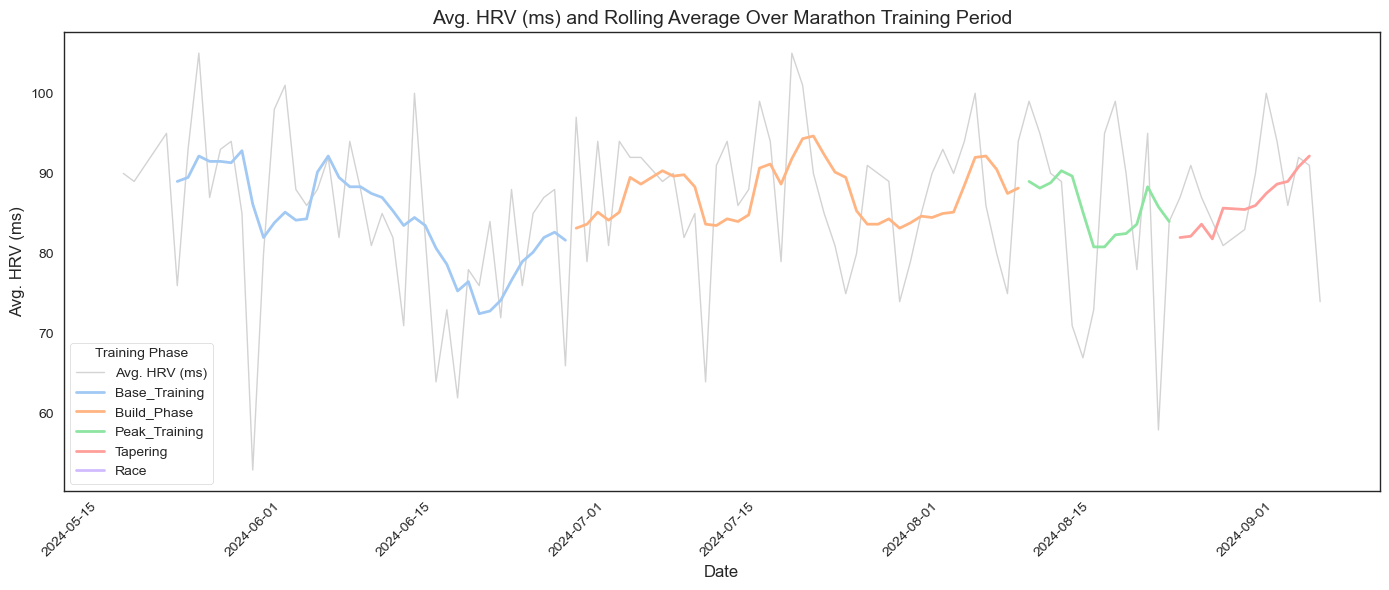

In [306]:
# Apply rolling average to Avg._HRVms
marathon_training_data['Rolling_Avg_HRVms'] = marathon_training_data['Avg._HRVms'].rolling(window=window_size).mean()

# Plot Avg. HRV (ms) and Rolling Average over time (Date)
plt.figure(figsize=(14, 6))

# Define a color palette for different training phases
palette = sns.color_palette("pastel", n_colors=marathon_training_data["Training_Phase"].nunique())

# Plot the original Avg. HRV in light gray
sns.lineplot(data=marathon_training_data, x='Date', y='Avg._HRVms', color='lightgray', label='Avg. HRV (ms)', linewidth=1)

# Plot the Rolling Average with colors mapped to 'Training_Phase'
sns.lineplot(data=marathon_training_data, x='Date', y='Rolling_Avg_HRVms', hue='Training_Phase', palette=palette, linewidth=2)

# Add labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Avg. HRV (ms)", fontsize=12)
plt.title("Avg. HRV (ms) and Rolling Average Over Marathon Training Period", fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(title="Training Phase")

# Display the plot
plt.tight_layout()

plt.savefig("hrv.png", dpi=300, bbox_inches='tight')

plt.show()

/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/3357175077.py:16: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/3357175077.py:32: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


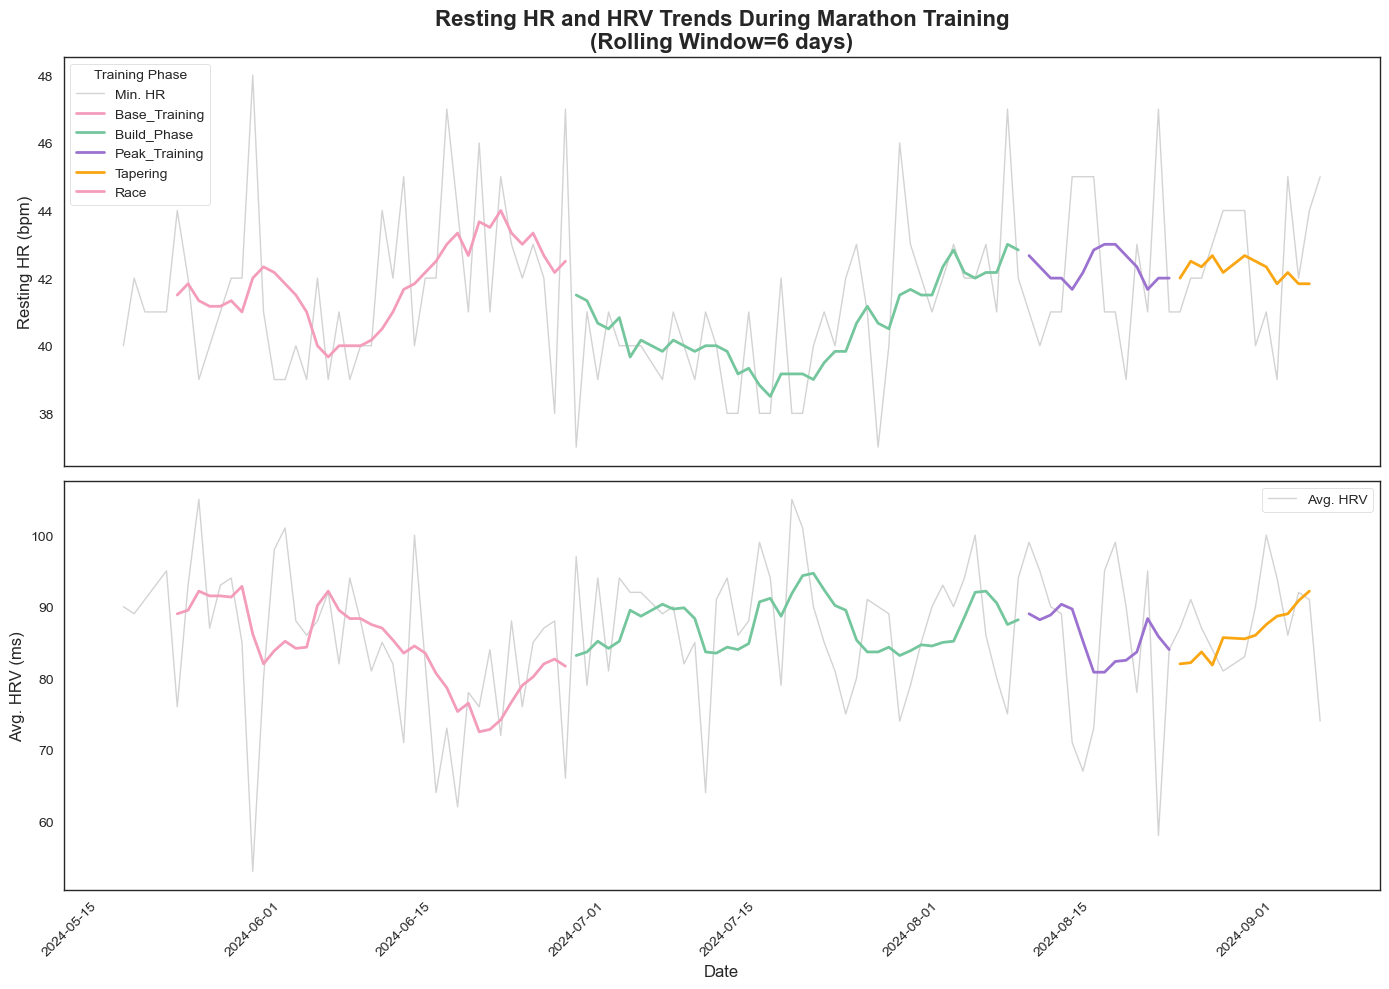

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Custom palette
custom_palette = ["#f49cbb", "#74c69d", "#9b72cf", "#faa613"]  # pink, coral, green, dark green
n_phases = marathon_training_data["Training_Phase"].nunique()
palette = custom_palette[:n_phases]  # ensure number of colors matches number of phases

# ---- Plot Resting HR ----
sns.lineplot(
    data=marathon_training_data, x='Date', y='Min._Heart_Ratebpm',
    color='lightgray', label='Min. HR', linewidth=1, ax=axes[0]
)
sns.lineplot(
    data=marathon_training_data, x='Date', y='RollingMinHR',
    hue='Training_Phase', palette=palette, linewidth=2, ax=axes[0]
)
axes[0].set_ylabel("Resting HR (bpm)")
axes[0].set_title(
    "Resting HR and HRV Trends During Marathon Training\n(Rolling Window=6 days)",
    fontsize=16,
    weight="bold"
)

# ---- Plot HRV ----
sns.lineplot(
    data=marathon_training_data, x='Date', y='Avg._HRVms',
    color='lightgray', label='Avg. HRV', linewidth=1, ax=axes[1]
)
sns.lineplot(
    data=marathon_training_data, x='Date', y='Rolling_Avg_HRVms',
    hue='Training_Phase', palette=palette, linewidth=2, ax=axes[1],
    legend=False
)
axes[1].set_ylabel("Avg. HRV (ms)")

# ---- Shared settings ----
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

axes[0].legend(title="Training Phase")
plt.tight_layout()
plt.savefig("combined_hr_hrv.png", dpi=300, bbox_inches='tight')
plt.show()

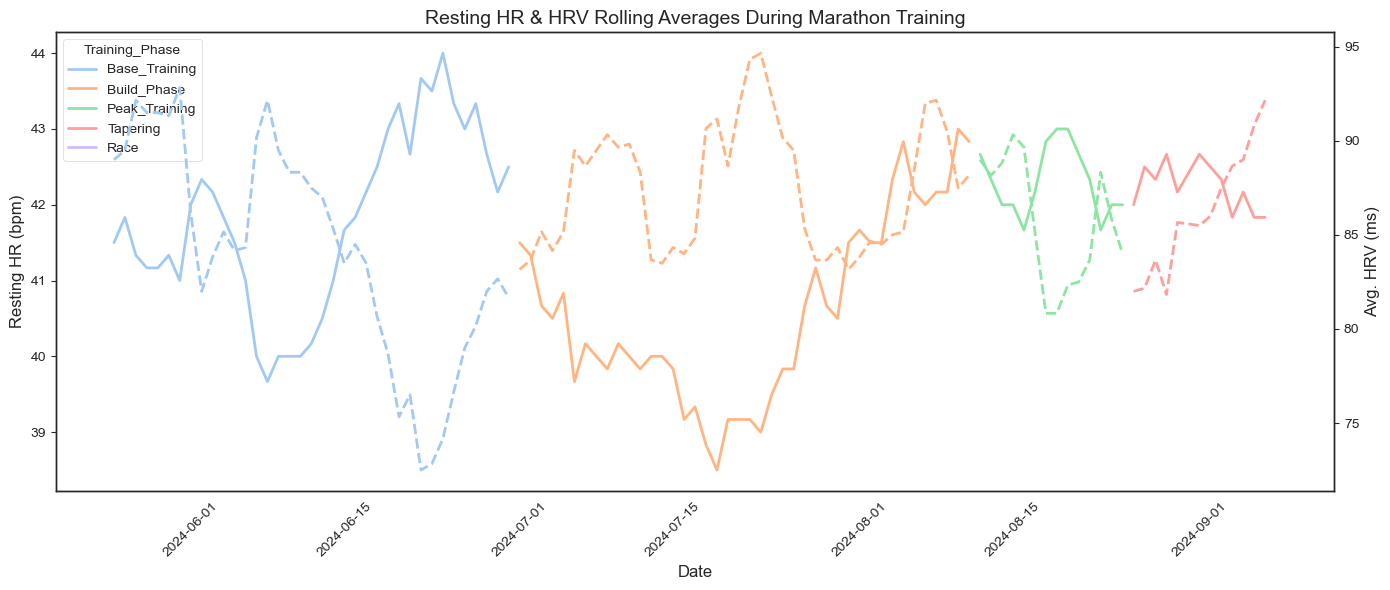

In [309]:
fig, ax1 = plt.subplots(figsize=(14, 6))

palette = sns.color_palette("pastel", n_colors=marathon_training_data["Training_Phase"].nunique())

# --- HR on left y-axis ---
sns.lineplot(data=marathon_training_data, x='Date', y='RollingMinHR',
             hue='Training_Phase', palette=palette, linewidth=2, ax=ax1)
ax1.set_ylabel("Resting HR (bpm)", fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# --- HRV on right y-axis ---
ax2 = ax1.twinx()
sns.lineplot(data=marathon_training_data, x='Date', y='Rolling_Avg_HRVms',
             hue='Training_Phase', palette=palette, linewidth=2, ax=ax2, legend=False, linestyle="--")
ax2.set_ylabel("Avg. HRV (ms)", fontsize=12)

plt.title("Resting HR & HRV Rolling Averages During Marathon Training", fontsize=14)
plt.tight_layout()
plt.show()

Overall, my resting heart rate gradually decreased and then stabilized compared to peak training, which suggests that my body was recovering well. At the same time, my average HRV steadily increased throughout the taper — another strong indicator that the taper was effective and my system was bouncing back.


## Recovery score 
* Track whether there is a consoistent relationship between a higher recovery score and a better long run performance 


In [310]:
long_run = marathon_training_data[
    (marathon_training_data["Distance"] > 9) & 
    (marathon_training_data["Distance"] < 22)
]

In [311]:
short_run=marathon_training_data[(marathon_training_data["Distance"]<9)]

In [312]:
long_run.columns

Index(['Date', 'Steps', 'Calorieskcal', 'Start_Time_x', 'End_Time',
       'Falling_Asleep_Time', 'Wakeup_time', 'Sleep_Time_Ratio',
       'Time_Asleepmin', 'Sleep_Stages__Awakemin', 'Sleep_Stages__REMmin',
       'Sleep_Stages__Light_Sleepmin', 'Sleep_Stages__Deep_Sleepmin',
       'Avg._Heart_Ratebpm', 'Min._Heart_Ratebpm', 'Max._Heart_Ratebpm',
       'Avg._Spo2', 'Min._Spo2', 'Max._Spo2', 'Avg._HRVms', 'Min._HRVms',
       'Max._HRVms', 'Activity_Name', 'Activity_Type', 'Distance',
       'Moving_Time', 'Max_Heart_Rate', 'Relative_Effort',
       'Average_Heart_Rate', 'Weather_Temperature', 'Humidity',
       'Apparent_Temperature', 'Elapsed_Time', 'Max_Speed', 'Average_Speed',
       'Start_Time_y', 'Elevation_Gain', 'Elevation_Loss', 'Average_Cadence',
       'Average_Grade_Adjusted_Pace', 'Start_Minutes',
       'Prev_Day_Relative_Effort', 'Avg._HRVms_scaled',
       'Min._Heart_Ratebpm_scaled', 'Time_Asleepmin_scaled',
       'Prev_Day_Relative_Effort_scaled', 'Sleep_Stages__D

In [313]:
print(long_run)

          Date    Steps  Calorieskcal         Start_Time_x  \
30  2024-05-31  26762.0        1945.0  2024-05-30 23:49:03   
44  2024-06-14  26287.0        1926.0  2024-06-14 00:05:57   
53  2024-06-23  31024.0        1984.0  2024-06-22 22:22:22   
58  2024-06-28  20584.0        1843.0  2024-06-28 02:14:13   
67  2024-07-07  30299.0        2057.0  2024-07-06 23:57:12   
74  2024-07-14  27971.0        2132.0  2024-07-14 00:08:33   
80  2024-07-19  36952.0        2197.0  2024-07-18 22:51:37   
88  2024-07-27  43871.0        2413.0  2024-07-27 00:08:16   
103 2024-08-11  41983.0        2260.0  2024-08-11 00:40:31   
110 2024-08-18  21696.0        1982.0  2024-08-17 23:14:43   
117 2024-08-25  38325.0        2008.0  2024-08-24 23:37:50   

               End_Time  Falling_Asleep_Time          Wakeup_time  \
30  2024-05-31 08:15:15  2024-05-30 23:56:33  2024-05-31 07:56:33   
44  2024-06-14 08:45:57  2024-06-14 00:25:57  2024-06-14 08:30:57   
53  2024-06-23 06:59:05  2024-06-22 22:49:52  20

In [314]:
print(long_run[["Date", "Average_Heart_Rate", "Distance", "Relative_Effort"]])

          Date  Average_Heart_Rate  Distance  Relative_Effort
30  2024-05-31          142.008957      9.03             74.0
44  2024-06-14          155.258514     11.02            178.0
53  2024-06-23          147.819611     12.01            141.0
58  2024-06-28          140.958801      9.10             83.0
67  2024-07-07          138.771362     14.03             98.0
74  2024-07-14          139.180817     13.10             84.0
80  2024-07-19          143.468460     15.12            130.0
88  2024-07-27          148.492416     17.03            202.0
103 2024-08-11          147.549591     19.01             71.0
110 2024-08-18          148.230423     10.51             54.0
117 2024-08-25          147.091782     20.01             82.0


In [325]:
long_run.count()

Date                                  11
Steps                                 11
Calorieskcal                          11
Start_Time_x                          11
End_Time                              11
Falling_Asleep_Time                   11
Wakeup_time                           11
Sleep_Time_Ratio                      11
Time_Asleepmin                        11
Sleep_Stages__Awakemin                11
Sleep_Stages__REMmin                  11
Sleep_Stages__Light_Sleepmin          11
Sleep_Stages__Deep_Sleepmin           11
Avg._Heart_Ratebpm                    11
Min._Heart_Ratebpm                    11
Max._Heart_Ratebpm                    11
Avg._Spo2                             11
Min._Spo2                             11
Max._Spo2                             11
Avg._HRVms                            11
Min._HRVms                            11
Max._HRVms                            11
Activity_Name                         11
Activity_Type                         11
Distance        

In [326]:
short_run.count()

Date                                  46
Steps                                 46
Calorieskcal                          46
Start_Time_x                          46
End_Time                              46
Falling_Asleep_Time                   46
Wakeup_time                           46
Sleep_Time_Ratio                      46
Time_Asleepmin                        46
Sleep_Stages__Awakemin                46
Sleep_Stages__REMmin                  46
Sleep_Stages__Light_Sleepmin          46
Sleep_Stages__Deep_Sleepmin           46
Avg._Heart_Ratebpm                    46
Min._Heart_Ratebpm                    46
Max._Heart_Ratebpm                    46
Avg._Spo2                             46
Min._Spo2                             46
Max._Spo2                             46
Avg._HRVms                            46
Min._HRVms                            46
Max._HRVms                            46
Activity_Name                         46
Activity_Type                         46
Distance        

In [319]:
#The original model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]

# Example predictor variables and target
X = long_run[["cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", "Humidity"]].dropna()
y = long_run.loc[X.index, "Relative_Effort"]

model3 = LinearRegression()
model3.fit(X, y)

coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model3.coef_
})
print(coeffs)
print(f"Intercept: {model.params[0]:.2f}")

y_pred = model3.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

long_run["predicted_effort"] = model3.predict(X)
long_run["effort_diff"] = long_run["Relative_Effort"] - long_run["predicted_effort"]

               Feature  Coefficient
0  cumulative_recovery    -0.486305
1       Time_Asleepmin     0.482258
2             Distance    -1.847867
3            Temp_Diff    29.878291
4             Humidity  -140.568736
Intercept: 1559.14
R² Score: 0.753
RMSE: 22.59


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1189797759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1189797759.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {model.params[0]:.2f}")
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1189797759.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [328]:
marathon_training_data.shape
short_run.count()

Date                                  46
Steps                                 46
Calorieskcal                          46
Start_Time_x                          46
End_Time                              46
Falling_Asleep_Time                   46
Wakeup_time                           46
Sleep_Time_Ratio                      46
Time_Asleepmin                        46
Sleep_Stages__Awakemin                46
Sleep_Stages__REMmin                  46
Sleep_Stages__Light_Sleepmin          46
Sleep_Stages__Deep_Sleepmin           46
Avg._Heart_Ratebpm                    46
Min._Heart_Ratebpm                    46
Max._Heart_Ratebpm                    46
Avg._Spo2                             46
Min._Spo2                             46
Max._Spo2                             46
Avg._HRVms                            46
Min._HRVms                            46
Max._HRVms                            46
Activity_Name                         46
Activity_Type                         46
Distance        

In [496]:
# Example predictor variables and target

short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]


X = short_run[["cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", "Humidity",'Elapsed_Time', 'Max_Speed', 'Average_Speed',
                 'Elevation_Gain', 'Elevation_Loss', 'Average_Grade_Adjusted_Pace']].dropna()

X = short_run[["cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", "Humidity",'Elapsed_Time',
                 'Elevation_Gain', 'Average_Grade_Adjusted_Pace']].dropna()


X = short_run[["cumulative_recovery", "Distance", "Temp_Diff", "Humidity",
                 'Elevation_Gain', 'Average_Grade_Adjusted_Pace']].dropna()


y = short_run.loc[X.index, "Relative_Effort"]

modelshort = LinearRegression()
modelshort.fit(X, y)

coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": modelshort.coef_
})
print(coeffs)
print(f"Intercept: {modelshort.intercept_:.2f}")


y_pred = modelshort.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")


                       Feature  Coefficient
0          cumulative_recovery     0.144003
1                     Distance    13.837859
2                    Temp_Diff    -1.949864
3                     Humidity   -30.253217
4               Elevation_Gain    -0.242171
5  Average_Grade_Adjusted_Pace    41.533320
Intercept: -141.14
R² Score: 0.810
RMSE: 13.16


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/731611225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]


In [497]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """Takes a DataFrame of predictors and returns VIF values."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    return vif_data

# Example usage:
# If you already have your predictors in a DataFrame called X:
vif_df = calculate_vif(X)
print(vif_df)

                       Feature         VIF
0          cumulative_recovery  102.262828
1                     Distance   12.593519
2                    Temp_Diff    1.130775
3                     Humidity   29.695082
4               Elevation_Gain    9.569953
5  Average_Grade_Adjusted_Pace  104.002413


In [458]:
# Example predictor variables and target

short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]


X = short_run[["cumulative_recovery", "Temp_Diff", "Humidity",'Elapsed_Time', 'Max_Speed',
             'Average_Grade_Adjusted_Pace']].dropna()
y = short_run.loc[X.index, "Relative_Effort"]

modelshort = LinearRegression()
modelshort.fit(X, y)

coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": modelshort.coef_
})
print(coeffs)
print(f"Intercept: {modelshort.intercept_:.2f}")


y_pred = modelshort.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")


                       Feature  Coefficient
0          cumulative_recovery     0.228185
1                    Temp_Diff    -0.963319
2                     Humidity   -38.305577
3                 Elapsed_Time     0.015464
4                    Max_Speed    -1.993356
5  Average_Grade_Adjusted_Pace    64.449790
Intercept: -211.65
R² Score: 0.740
RMSE: 15.37


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1874156418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]


In [459]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """Takes a DataFrame of predictors and returns VIF values."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    return vif_data

# Example usage:
# If you already have your predictors in a DataFrame called X:
vif_df = calculate_vif(X)
print(vif_df)

                       Feature         VIF
0          cumulative_recovery  106.567473
1                    Temp_Diff    1.140371
2                     Humidity   28.582208
3                 Elapsed_Time    7.203614
4                    Max_Speed    8.306062
5  Average_Grade_Adjusted_Pace  113.519549


In [483]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

# --- Prepare features and target ---
short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]
long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]


# Full predictor set
X_full = short_run[[
    "cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", 
    "Humidity", 'Max_Speed', 'Average_Speed',
    'Elevation_Gain',
]].dropna()

y = short_run.loc[X_full.index, "Relative_Effort"]

# Reduced predictor set (example: drop highly collinear ones)
X_reduced = short_run[[
    "cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", 
    "Humidity", 'Max_Speed', 'Elevation_Gain'
]].dropna()

y_reduced = short_run.loc[X_reduced.index, "Relative_Effort"]

# --- RidgeCV model ---
alphas = np.logspace(-3, 3, 50)  # search range for regularization

ridge_full = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_full.fit(X_full, y)
y_pred_full = ridge_full.predict(X_full)
r2_full = r2_score(y, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))

ridge_reduced = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_reduced.fit(X_reduced, y_reduced)
y_pred_reduced = ridge_reduced.predict(X_reduced)
r2_reduced = r2_score(y_reduced, y_pred_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_reduced, y_pred_reduced))

# --- Print comparison ---
print("FULL MODEL:")
print(f"Alpha: {ridge_full.alpha_:.3f}")
print(f"R²: {r2_full:.3f}")
print(f"RMSE: {rmse_full:.2f}")

print("\nREDUCED MODEL:")
print(f"Alpha: {ridge_reduced.alpha_:.3f}")
print(f"R²: {r2_reduced:.3f}")
print(f"RMSE: {rmse_reduced:.2f}")

FULL MODEL:
Alpha: 0.655
R²: 0.799
RMSE: 13.52

REDUCED MODEL:
Alpha: 0.373
R²: 0.740
RMSE: 15.38


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1369307622.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [500]:
# --- Prepare features and target ---
short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]
long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]

# Full predictor set
X_full_train = short_run[[
    "cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", 
    "Humidity", 'Max_Speed', 'Average_Speed', 'Elevation_Gain'
]].dropna()

y_train_full = short_run.loc[X_full_train.index, "Relative_Effort"]

X_full_test = long_run[X_full_train.columns].dropna()
y_test_full = long_run.loc[X_full_test.index, "Relative_Effort"]

# Reduced predictor set
X_reduced_train = short_run[[
    "cumulative_recovery", "Distance", "Temp_Diff", 
    "Humidity", 'Elevation_Gain'
]].dropna()

y_train_reduced = short_run.loc[X_reduced_train.index, "Relative_Effort"]

X_reduced_test = long_run[X_reduced_train.columns].dropna()
y_test_reduced = long_run.loc[X_reduced_test.index, "Relative_Effort"]

# --- RidgeCV model ---
alphas = np.logspace(-3, 3, 50)

ridge_full = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_full.fit(X_full_train, y_train_full)

ridge_reduced = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_reduced.fit(X_reduced_train, y_train_reduced)

# --- Predictions ---
y_pred_full_test = ridge_full.predict(X_full_test)
y_pred_reduced_test = ridge_reduced.predict(X_reduced_test)

# --- Evaluate on LONG RUN test set ---
r2_full_test = r2_score(y_test_full, y_pred_full_test)
rmse_full_test = np.sqrt(mean_squared_error(y_test_full, y_pred_full_test))

r2_reduced_test = r2_score(y_test_reduced, y_pred_reduced_test)
rmse_reduced_test = np.sqrt(mean_squared_error(y_test_reduced, y_pred_reduced_test))

print("FULL MODEL (tested on long runs):")
print(f"Alpha: {ridge_full.alpha_:.3f}")
print(f"R²: {r2_full_test:.3f}")
print(f"RMSE: {rmse_full_test:.2f}")

print("\nREDUCED MODEL (tested on long runs):")
print(f"Alpha: {ridge_reduced.alpha_:.3f}")
print(f"R²: {r2_reduced_test:.3f}")
print(f"RMSE: {rmse_reduced_test:.2f}")

FULL MODEL (tested on long runs):
Alpha: 0.655
R²: -1.616
RMSE: 73.50

REDUCED MODEL (tested on long runs):
Alpha: 0.212
R²: -2.045
RMSE: 79.31


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2365824052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_run["Temp_Diff"] = short_run["Apparent_Temperature"] - short_run["Weather_Temperature"]
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/2365824052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge

In [484]:
coeffs = pd.DataFrame({
    "Feature": X_reduced.columns,
    "Coefficient": ridge_reduced.coef_
})

print(coeffs)

               Feature  Coefficient
0  cumulative_recovery     0.107694
1       Time_Asleepmin    -0.058569
2             Distance    16.200881
3            Temp_Diff    -2.262012
4             Humidity   -19.681455
5            Max_Speed    -0.622661
6       Elevation_Gain    -0.213400


In [478]:
coeffs = pd.DataFrame({
    "Feature": X_full.columns,
    "Coefficient": ridge_full.coef_
})

print(coeffs)

               Feature  Coefficient
0  cumulative_recovery     0.105935
1       Time_Asleepmin    -0.027663
2             Distance    14.619448
3            Temp_Diff    -1.918503
4             Humidity   -12.704054
5            Max_Speed    -1.360702
6        Average_Speed    31.037096
7       Elevation_Gain    -0.189627


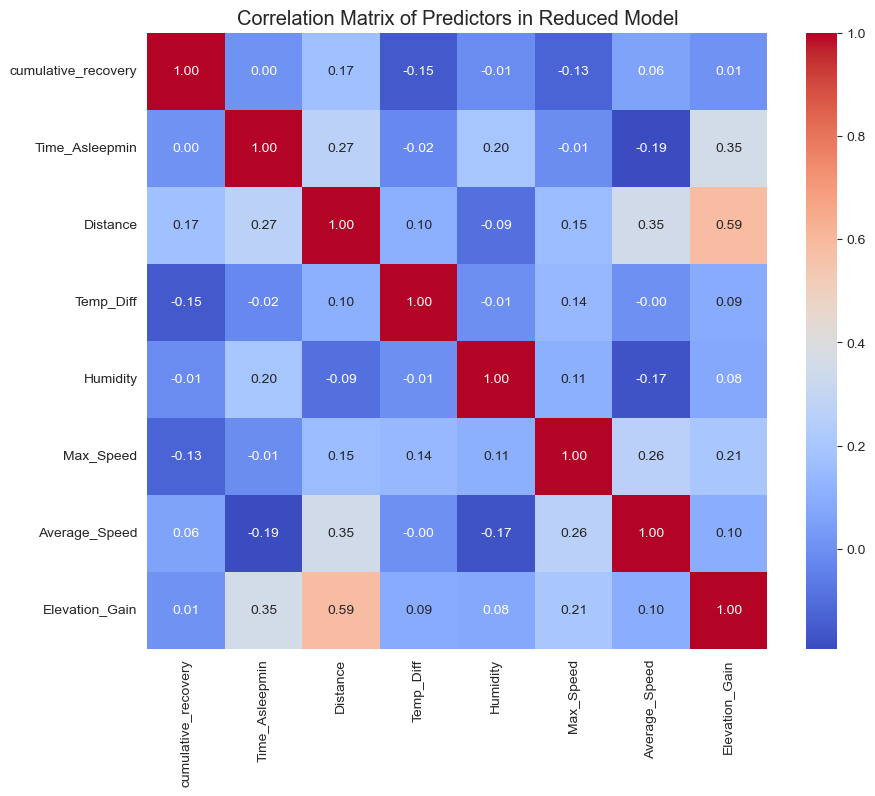

In [479]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X_full.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Predictors in Reduced Model")
plt.show()

     Actual_RE  Predicted_RE  Difference
30        74.0    110.729731   36.729731
47       178.0    119.375248  -58.624752
56       141.0    110.515112  -30.484888
61        83.0    105.634295   22.634295
70        98.0    144.537921   46.537921
77        84.0    135.370685   51.370685
83       130.0    178.492308   48.492308
91       202.0    191.448502  -10.551498
106       71.0    213.463483  142.463483
113       54.0    100.812536   46.812536
120       82.0    228.921388  146.921388


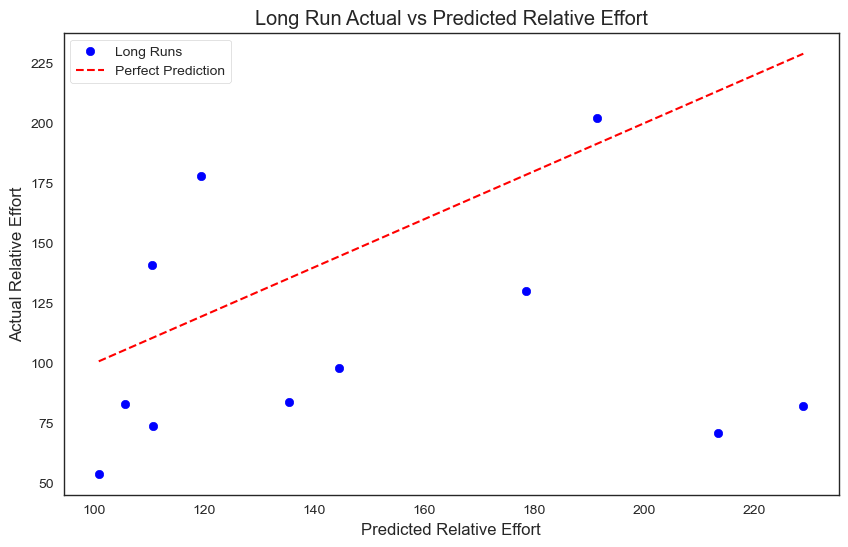

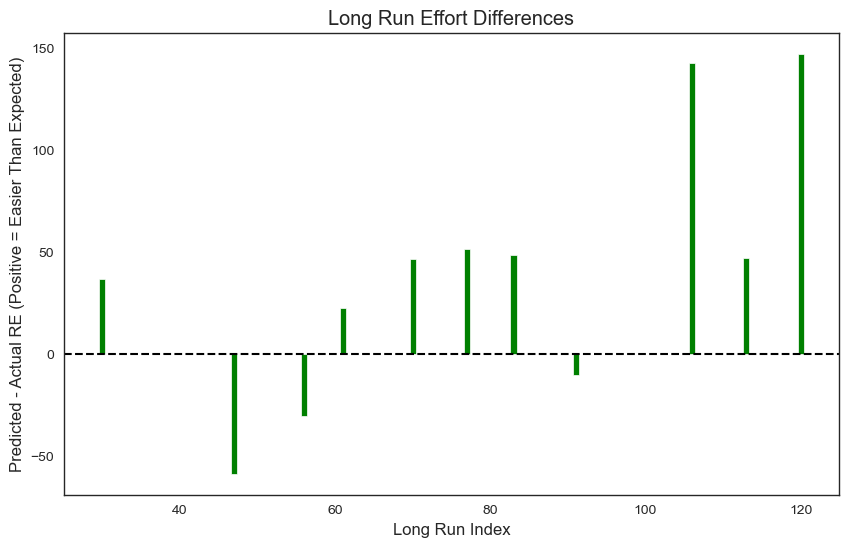

In [467]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose which model to use
model = ridge_reduced  # or reduced_model

# Select the same predictors you used in your model
predictors = X_reduced.columns  # or reduced_X.columns if using reduced_model

# Make sure the long run data has the same columns and drop NA rows
X_long = long_run[predictors].dropna()
y_long_actual = long_run.loc[X_long.index, "Relative_Effort"]

# Predict the expected relative effort
y_long_pred = model.predict(X_long)

# Combine actual vs predicted in a DataFrame
results = pd.DataFrame({
    "Actual_RE": y_long_actual,
    "Predicted_RE": y_long_pred
})
results["Difference"] = results["Predicted_RE"] - results["Actual_RE"]  # positive = easier than expected

# Quick summary
print(results)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(results["Predicted_RE"], results["Actual_RE"], color='blue', label='Long Runs')
plt.plot([results["Predicted_RE"].min(), results["Predicted_RE"].max()],
         [results["Predicted_RE"].min(), results["Predicted_RE"].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Predicted Relative Effort")
plt.ylabel("Actual Relative Effort")
plt.title("Long Run Actual vs Predicted Relative Effort")
plt.legend()
plt.show()

# Optional: visualize difference
plt.figure(figsize=(10,6))
plt.bar(results.index, results["Difference"], color='green')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Long Run Index")
plt.ylabel("Predicted - Actual RE (Positive = Easier Than Expected)")
plt.title("Long Run Effort Differences")
plt.show()

In [462]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define predictors and target
X = short_run[["cumulative_recovery", "Temp_Diff", "Humidity",
               "Elapsed_Time", "Max_Speed", "Average_Grade_Adjusted_Pace"]].dropna()
y = short_run.loc[X.index, "Relative_Effort"]

# Ridge Regression
ridge = Ridge(alpha=10)   # alpha controls regularization strength
ridge.fit(X, y)
y_pred_ridge = ridge.predict(X)

ridge_r2 = r2_score(y, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y, y_pred_ridge))

print("Ridge Results")
print(f"R²: {ridge_r2:.3f}")
print(f"RMSE: {ridge_rmse:.2f}")
print("Coefficients:", dict(zip(X.columns, ridge.coef_)))
print(f"Intercept: {ridge.intercept_:.2f}\n")

# Lasso Regression
lasso = Lasso(alpha=0.1)   # smaller alpha keeps more features, larger alpha shrinks more
lasso.fit(X, y)
y_pred_lasso = lasso.predict(X)

lasso_r2 = r2_score(y, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y, y_pred_lasso))

print("Lasso Results")
print(f"R²: {lasso_r2:.3f}")
print(f"RMSE: {lasso_rmse:.2f}")
print("Coefficients:", dict(zip(X.columns, lasso.coef_)))
print(f"Intercept: {lasso.intercept_:.2f}")

Ridge Results
R²: 0.576
RMSE: 19.65
Coefficients: {'cumulative_recovery': 0.24287642622106814, 'Temp_Diff': -1.162668132260593, 'Humidity': -3.1268618158659702, 'Elapsed_Time': 0.017571056403844047, 'Max_Speed': -0.545628342068843, 'Average_Grade_Adjusted_Pace': 10.432675163207731}
Intercept: -97.51

Lasso Results
R²: 0.739
RMSE: 15.40
Coefficients: {'cumulative_recovery': 0.22906397604662787, 'Temp_Diff': -0.9214677620995119, 'Humidity': -31.638451851762866, 'Elapsed_Time': 0.015559965890926035, 'Max_Speed': -1.9594630228374081, 'Average_Grade_Adjusted_Pace': 62.55399680024255}
Intercept: -211.32


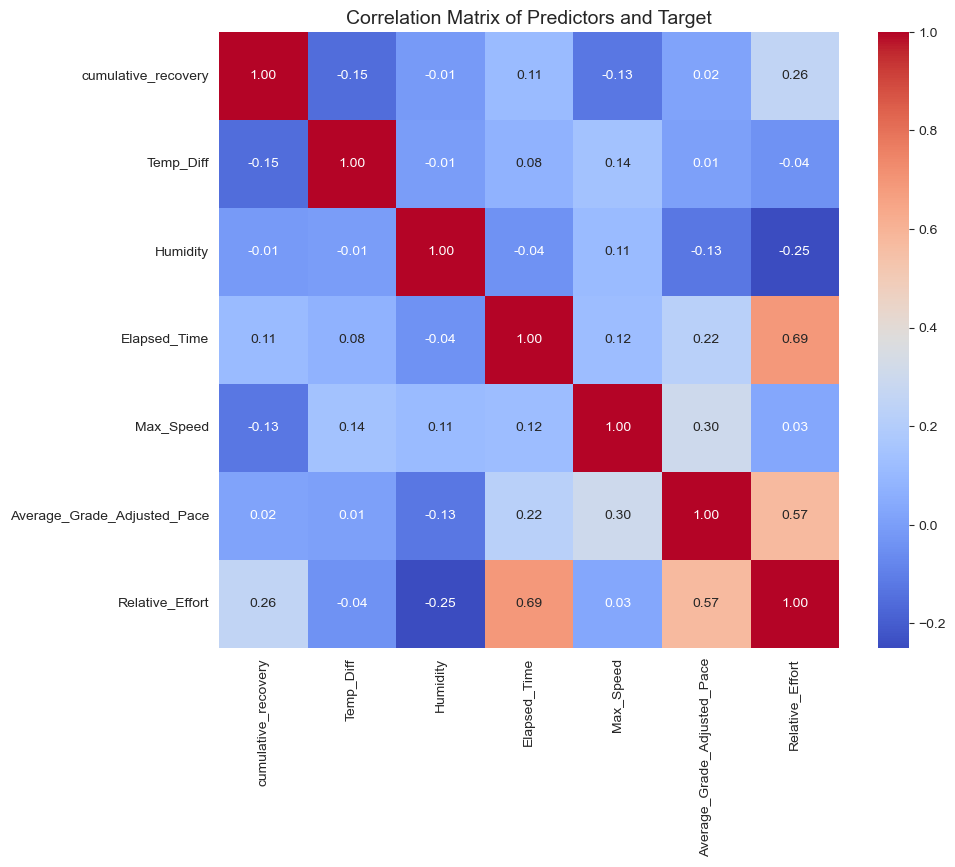

In [461]:
import matplotlib.pyplot as plt
import seaborn as sns

# Include predictors and the target
corr_df = X.copy()
corr_df["Relative_Effort"] = y

# Compute correlations
corr_matrix = corr_df.corr()

# Display correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Predictors and Target", fontsize=14)
plt.show()

In [ ]:
print(short_run).columns

In [338]:
# Predict on long runs
long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]


X_long = long_run[["cumulative_recovery", "Time_Asleepmin", "Distance", "Temp_Diff", "Humidity",'Elapsed_Time', 'Max_Speed', 'Average_Speed',
                 'Elevation_Gain', 'Elevation_Loss', 'Average_Grade_Adjusted_Pace']].dropna()
long_run["predicted_effort"] = modelshort.predict(X_long)

# Compare actual vs predicted
long_run["effort_diff"] = long_run["Relative_Effort"] - long_run["predicted_effort"]

/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1974284202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_run["Temp_Diff"] = long_run["Apparent_Temperature"] - long_run["Weather_Temperature"]
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1974284202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_run["predicted_effort"] = modelshort.predict(X_long)
/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/1974284202.py:10: SettingWithCopyWarning: 

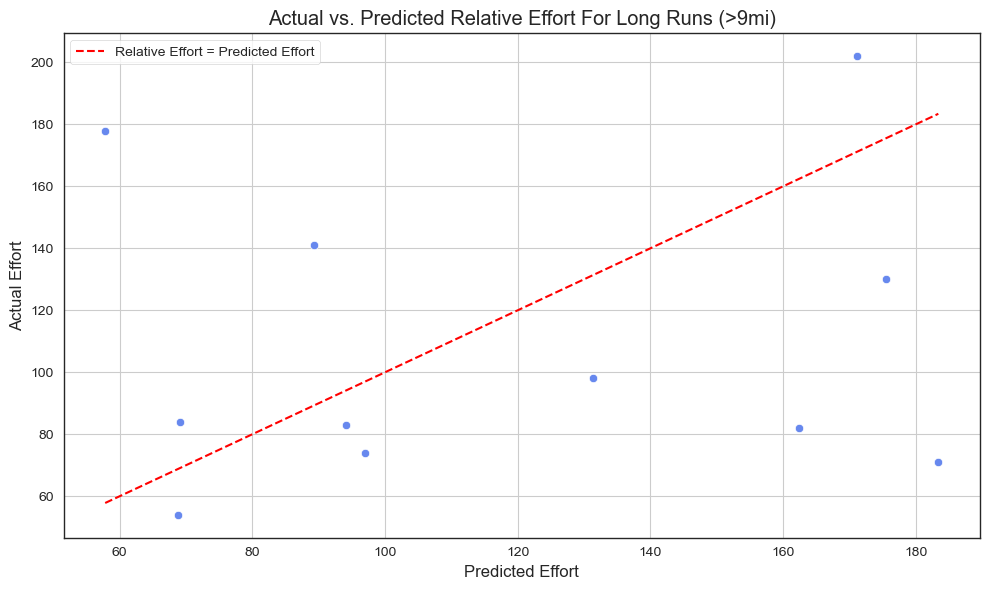

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(x=long_run["predicted_effort"], y=long_run["Relative_Effort"])
plt.plot([long_run["predicted_effort"].min(), long_run["predicted_effort"].max()],
          [long_run["predicted_effort"].min(), long_run["predicted_effort"].max()],
          color='red', linestyle='--', label='Relative Effort = Predicted Effort')
plt.xlabel("Predicted Effort")
plt.ylabel("Actual Effort")
plt.title("Actual vs. Predicted Relative Effort For Long Runs (>9mi)")
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.set_style("white")
plt.savefig("longgraph.png", dpi=300, bbox_inches='tight')

plt.show()

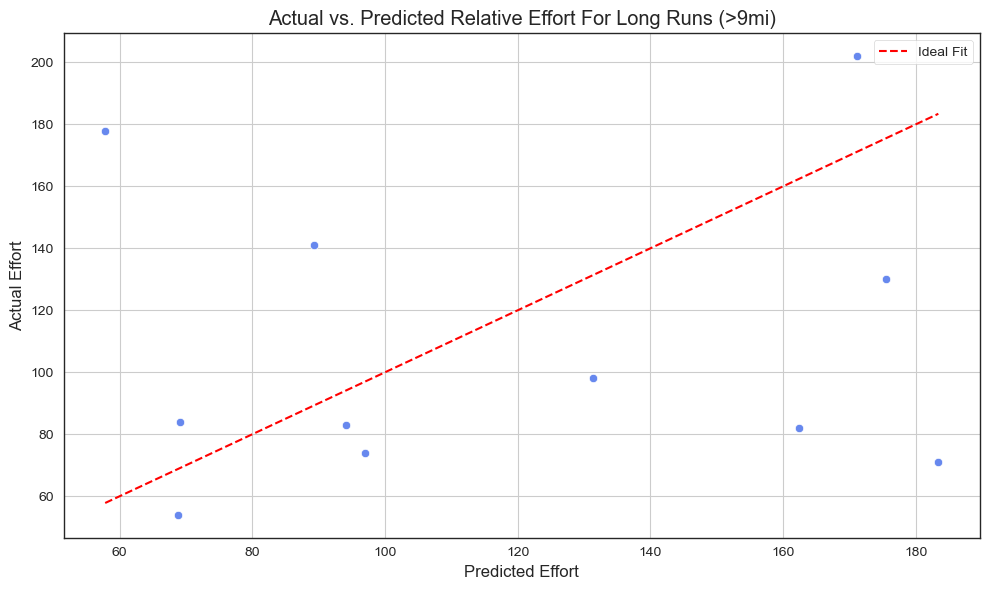

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(x=long_run["predicted_effort"], y=long_run["Relative_Effort"])
plt.plot([long_run["predicted_effort"].min(), long_run["predicted_effort"].max()],
          [long_run["predicted_effort"].min(), long_run["predicted_effort"].max()],
          color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Predicted Effort")
plt.ylabel("Actual Effort")
plt.title("Actual vs. Predicted Relative Effort For Long Runs (>9mi)")
plt.legend()
plt.grid(True)
plt.tight_layout()
sns.set_style("white")
plt.savefig("longgraph.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#plt.figure(figsize=(10, 6))
#sns.lineplot(data=long_run, x=long_run.index, y="effort_diff", marker="o")
#plt.axhline(0, color='gray', linestyle='--')
#plt.title("Difference Between Actual and Predicted Effort Across Long Runs")
#plt.xticks(ticks=range(len(long_run)), labels=range(1, 11))

#plt.xlabel("Long Run Index")
#plt.ylabel("Effort Difference")
#plt.grid(True)
#plt.tight_layout()
#plt.savefig("longrunline.png", dpi=300, bbox_inches='tight')

#plt.show()

/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/4188049268.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=long_run.reset_index(), x="index", y="effort_diff", palette="coolwarm")


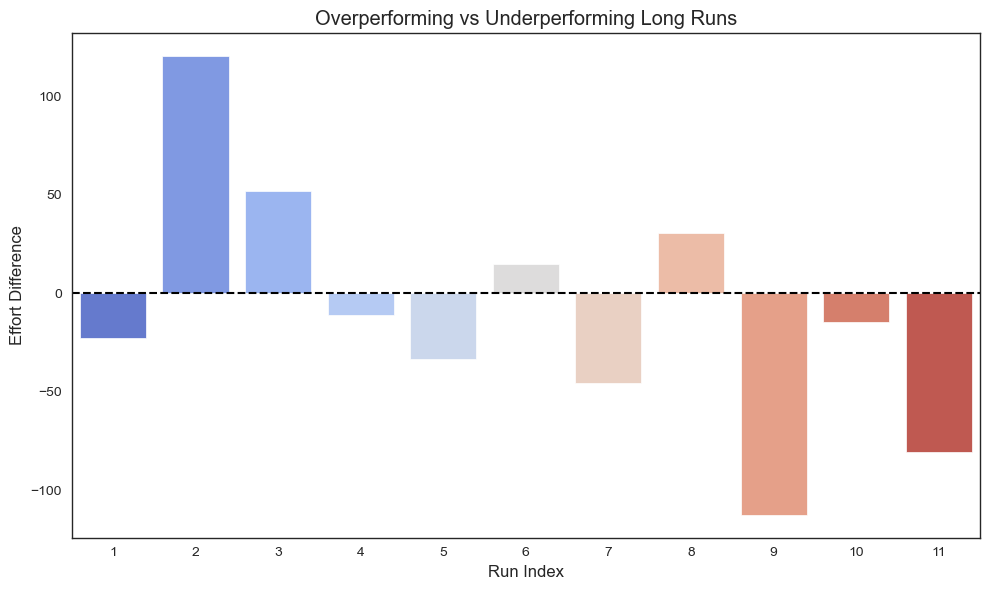

In [343]:
plt.figure(figsize=(10, 6))
sns.barplot(data=long_run.reset_index(), x="index", y="effort_diff", palette="coolwarm")
plt.axhline(0, color='black', linestyle='--')
plt.title("Overperforming vs Underperforming Long Runs")
plt.xticks(ticks=range(len(long_run)), labels=range(1, len(long_run) + 1))
plt.xlabel("Run Index")
plt.ylabel("Effort Difference")
plt.tight_layout()
sns.set_style("white")
plt.savefig("longrunbar.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
long_run.tail()

In [511]:
##Starting over with the model

for df in [short_run, long_run]:
    df["Temp_Diff"] = df["Apparent_Temperature"] - df["Weather_Temperature"]

    
predictors = [
    "cumulative_recovery",
    "Time_Asleepmin",
    "Distance",
    "Temp_Diff",
    "Humidity",
    "Max_Speed",
    "Elevation_Gain",
    "Average_Grade_Adjusted_Pace"
]


# Drop rows with missing values in selected predictors
X_short = short_run[predictors].dropna()
y_short = short_run.loc[X_short.index, "Relative_Effort"]

X_long = long_run[predictors].dropna()
y_long = long_run.loc[X_long.index, "Relative_Effort"]



alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(X_short, y_short)

y_pred_short = ridge.predict(X_short)
r2_short = r2_score(y_short, y_pred_short)
rmse_short = np.sqrt(mean_squared_error(y_short, y_pred_short))

print(f"Ridge Alpha (short runs): {ridge.alpha_:.3f}")
print(f"R² (short runs): {r2_short:.3f}")
print(f"RMSE (short runs): {rmse_short:.2f}")

y_pred_long = ridge.predict(X_long)

# Compute undertraining metric
long_run_results = X_long.copy()
long_run_results["Actual_RE"] = y_long
long_run_results["Predicted_RE"] = y_pred_long
long_run_results["Diff"] = y_long - y_pred_long  # Positive = undertrained

# Coefficients
coeffs = pd.DataFrame({
    "Feature": X_long.columns,
    "Coefficient": ridge.coef_
})

print(coeffs)

# Intercept
print(f"Intercept: {ridge.intercept_:.2f}")

# Best alpha chosen
print(f"Chosen alpha: {ridge.alpha_:.3f}")

Ridge Alpha (short runs): 0.869
R² (short runs): 0.807
RMSE (short runs): 13.24
                       Feature  Coefficient
0          cumulative_recovery     0.118420
1               Time_Asleepmin    -0.026031
2                     Distance    14.725903
3                    Temp_Diff    -1.855426
4                     Humidity   -11.482290
5                    Max_Speed    -1.430744
6               Elevation_Gain    -0.224096
7  Average_Grade_Adjusted_Pace    30.157258
Intercept: -99.97
Chosen alpha: 0.869


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/3979113011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Temp_Diff"] = df["Apparent_Temperature"] - df["Weather_Temperature"]
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


/var/folders/7g/y70jz2ks10xdctq8v1dd7_qw0000gn/T/ipykernel_49445/3885929953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


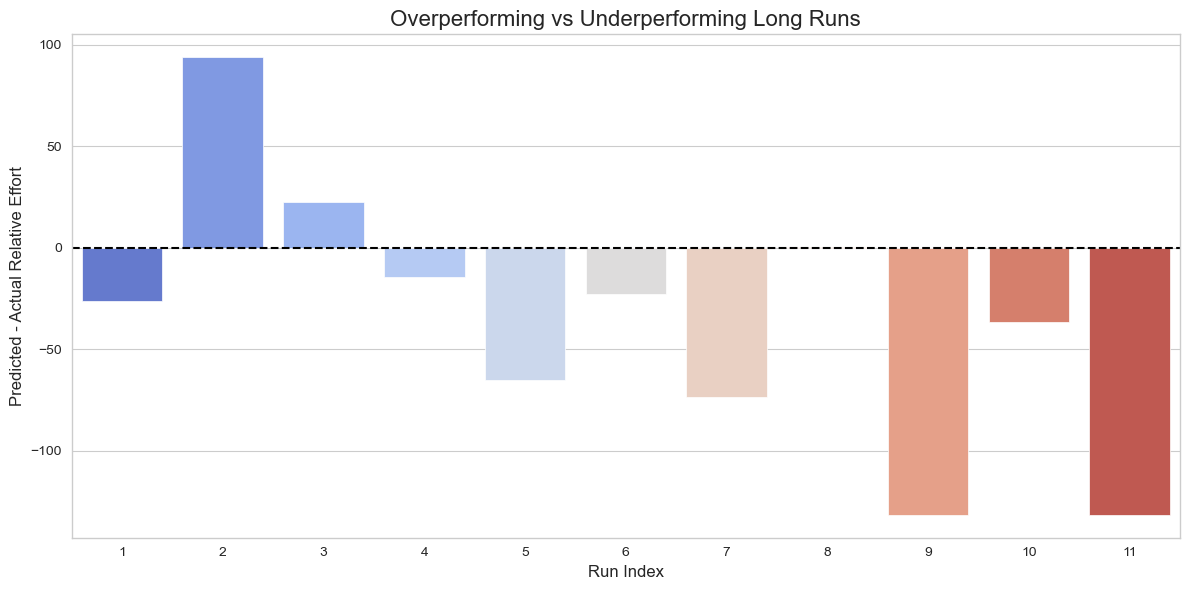

In [514]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create barplot
sns.barplot(
    data=long_run_results.reset_index(), 
    x="index",        # or "Run_Index" if your column is named that
    y="Diff", 
    palette="coolwarm"
)

# Add a horizontal line at 0
plt.axhline(0, color='black', linestyle='--')

# Labels and title
plt.title("Overperforming vs Underperforming Long Runs", fontsize=16)
plt.xlabel("Run Index", fontsize=12)
plt.ylabel("Predicted - Actual Relative Effort", fontsize=12)

# Adjust x-ticks
plt.xticks(ticks=range(len(long_run_results)), labels=range(1, len(long_run_results) + 1))

plt.tight_layout()

# Save figure
plt.savefig("longrun_effort_diff.png", dpi=300, bbox_inches='tight')

plt.show()

     Actual_RE  Predicted_RE        Diff
30        74.0    100.244972  -26.244972
47       178.0     84.090550   93.909450
56       141.0    118.679505   22.320495
61        83.0     97.348148  -14.348148
70        98.0    163.229298  -65.229298
77        84.0    106.945896  -22.945896
83       130.0    203.518911  -73.518911
91       202.0    201.686761    0.313239
106       71.0    202.678243 -131.678243
113       54.0     90.479135  -36.479135
120       82.0    213.714095 -131.714095


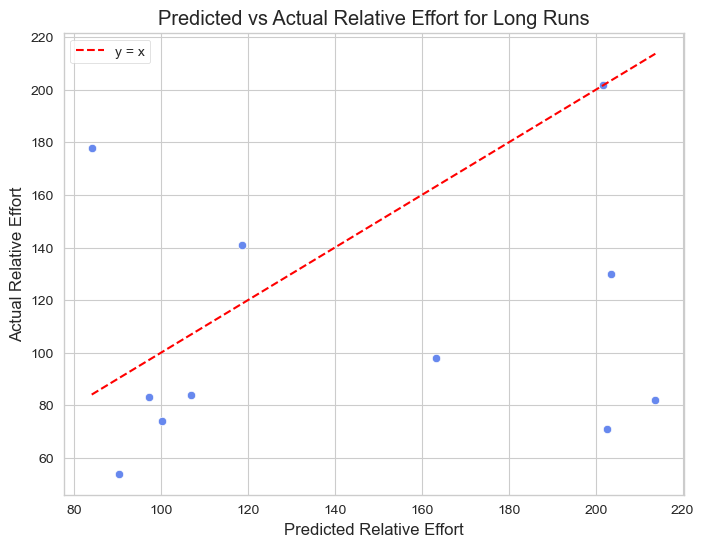

In [512]:
print(long_run_results[["Actual_RE", "Predicted_RE", "Diff"]])

# Plot predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x="Predicted_RE", y="Actual_RE", data=long_run_results)
plt.plot([long_run_results["Predicted_RE"].min(), long_run_results["Predicted_RE"].max()],
         [long_run_results["Predicted_RE"].min(), long_run_results["Predicted_RE"].max()],
         color='red', linestyle='--', label="y = x")
plt.xlabel("Predicted Relative Effort")
plt.ylabel("Actual Relative Effort")
plt.title("Predicted vs Actual Relative Effort for Long Runs")
plt.legend()
plt.savefig("modelnew.png")
plt.show()

# Optional: histogram of differences
#plt.figure(figsize=(8,4))
#sns.histplot(long_run_results["Diff"], kde=True)
#plt.xlabel("Predicted - Actual Relative Effort")
#plt.title("Undertraining Metric (Positive = Easier than Predicted)")
#plt.show()

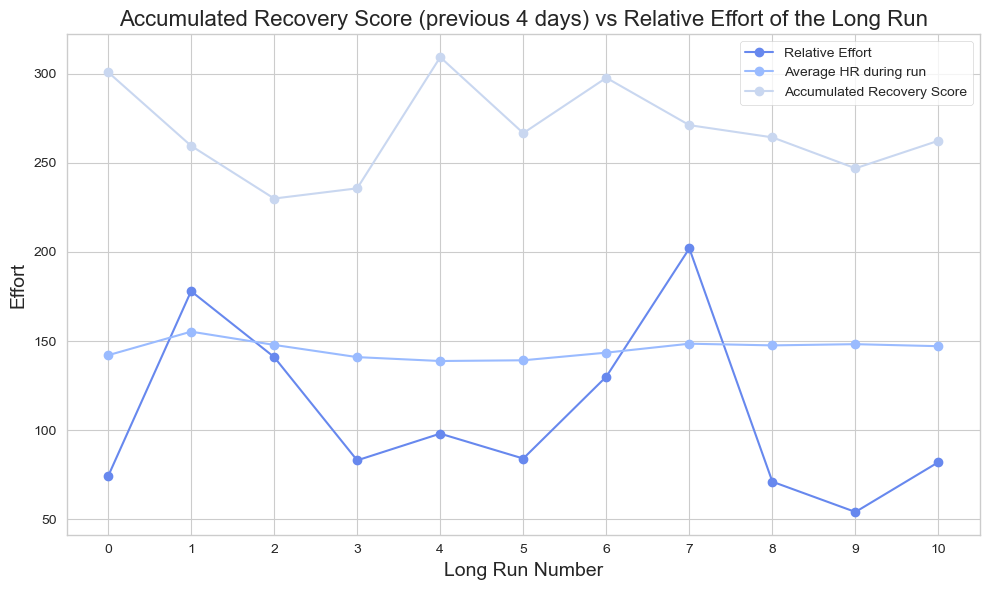

In [513]:
# Reset index to get a clean x-axis (optional but makes the plot cleaner if no date axis is used)
long_run = long_run.reset_index(drop=True)

plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(long_run.index, long_run["Relative_Effort"], label="Relative Effort", marker='o')
plt.plot(long_run.index, long_run["Average_Heart_Rate"], label="Average HR during run", marker='o')
plt.plot(long_run.index, long_run["cumulative_recovery"], label="Accumulated Recovery Score", marker='o')


# Customize plot
plt.title("Accumulated Recovery Score (previous 4 days) vs Relative Effort of the Long Run", fontsize=16)
plt.xlabel("Long Run Number", fontsize=14)
plt.ylabel("Effort", fontsize=14)
plt.xticks(long_run.index)  
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Create a scaler
scaler = MinMaxScaler()

# Select the columns you want to normalize and reshape them for the scaler
data_to_scale = long_run[["Relative_Effort", "cumulative_recovery", "Average_Heart_Rate"]]

# Fit and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Convert back to DataFrame for easier plotting
scaled_df = pd.DataFrame(scaled_data, columns=["Relative_Effort", "cumulative_recovery","Average_Heart_Rate"])

# Reset index if needed (you did it already, so just make sure it's aligned)
scaled_df.index = long_run.index

plt.figure(figsize=(10, 6))

# Plot normalized values
plt.plot(scaled_df.index, scaled_df["Relative_Effort"], label="Relative Effort (Normalized)", marker='o')
plt.plot(scaled_df.index, scaled_df["cumulative_recovery"], label="Accumulated Recovery Score (Normalized)", marker='o', color='green')
plt.plot(scaled_df.index, scaled_df["Average_Heart_Rate"], label="Average Heart Rate (Normalized)", marker='o', color='deeppink')


plt.title("Normalized Accumulated Recovery Score vs Relative Effort of Long Runs", fontsize=16)
plt.xticks(ticks=range(len(long_run)), labels=range(1, len(long_run)+1))

plt.xlabel("Long Run Index", fontsize=14)
plt.ylabel("Normalized Effort / Recovery", fontsize=14)
#plt.xticks(scaled_df.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
# Calculate Pearson correlation on scaled data
corr_scaled, p_value_scaled = pearsonr(scaled_df["cumulative_recovery"], scaled_df["Relative_Effort"])

# Plot the scatter with regression line for normalized values
plt.figure(figsize=(8, 6))
sns.regplot(
    x=scaled_df["cumulative_recovery"],
    y=scaled_df["Relative_Effort"],
    marker="o",
    color="teal",
    scatter_kws={"s": 60}
)

# Title includes Pearson r and p-value
plt.title(f"Normalized Recovery vs. Effort\nPearson r = {corr_scaled:.2f}, p = {p_value_scaled:.3f}", fontsize=14)
plt.xlabel("Accumulated Recovery Score (Normalized)", fontsize=12)
plt.ylabel("Relative Effort (Normalized)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(long_run['cumulative_recovery'], 
                         long_run['Relative_Effort'])

print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

In [ ]:
import seaborn as sns

sns.lmplot(data=long_run, x="cumulative_recovery", y="Relative_Effort")

In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(long_run['Average_Heart_Rate'], 
                         long_run['cumulative_recovery'])

print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

In [ ]:
# Reset index to get a clean x-axis (optional but makes the plot cleaner if no date axis is used)
long_run = long_run.reset_index(drop=True)

# Optional: normalize all metrics for visual comparability
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
long_run_scaled = long_run.copy()
metrics_to_scale = ["Relative_Effort", "cumulative_recovery", "Average_Heart_Rate"]
long_run_scaled[metrics_to_scale] = scaler.fit_transform(long_run[metrics_to_scale])

# Plot
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(long_run_scaled.index, long_run_scaled["Relative_Effort"], label="Relative Effort", marker='o', color="red")
plt.plot(long_run_scaled.index, long_run_scaled["cumulative_recovery"], label="Accumulated Recovery Score", marker='o')
plt.plot(long_run_scaled.index, long_run_scaled["Average_Heart_Rate"], label="Average Heart Rate", marker='o')

# Customize
plt.title("Long Run Trends: Effort, Recovery, and Avg. Heart Rate", fontsize=16)
plt.xlabel("Long Run Number", fontsize=14)
plt.ylabel("Normalized Value", fontsize=14)
plt.xticks(long_run_scaled.index)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(long_run['Average_Heart_Rate'], 
                         long_run['Relative_Effort'])

print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

In [ ]:
from scipy.stats import spearmanr

# Drop NA values (important!)
subset = long_run[["cumulative_recovery", "Relative_Effort"]].dropna()

# Spearman correlation
rho, p_value = spearmanr(subset["cumulative_recovery"], subset["Relative_Effort"])

print(f"Spearman correlation: {rho:.3f}")
print(f"P-value: {p_value:.3f}")

In [ ]:
from scipy.stats import spearmanr

corr, pval = spearmanr(long_run["Average_Heart_Rate"], long_run["Relative_Effort"])
print(f"Spearman correlation: {corr:.3f}")
print(f"P-value: {pval:.3f}")

In [ ]:
from scipy.stats import spearmanr

corr, pval = spearmanr(long_run["Average_Heart_Rate"], long_run["cumulative_recovery"])
print(f"Spearman correlation: {corr:.3f}")
print(f"P-value: {pval:.3f}")

## Considering Weather During My Runs

In [ ]:
# Select only the columns you're interested in
corr_columns = [
    "Average_Heart_Rate",
    "Relative_Effort",
    "Apparent_Temperature",
    "Weather_Temperature",
    "Humidity"
]

# Drop rows with missing values in these columns
subset = master_df[corr_columns].dropna()

# Compute correlation matrix
corr_matrix = subset.corr(method='spearman')  # or method='pearson'

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# # Select only the columns you're interested in
# corr_columns = [
#     "Average_Heart_Rate",
#     "Relative_Effort",
#     "Apparent_Temperature",
#     "Weather_Temperature",
#     "Humidity"
# ]

# # Drop rows with missing values in these columns
# subset = master_df[corr_columns].dropna()

# # Compute correlation matrix
# corr_matrix = subset.corr(method='pearson')  # or method='pearson'

# # Plot correlation heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
# plt.title("All Runs Correlation Matrix")
# plt.tight_layout()
# plt.savefig("corr_allruns.png", dpi=300, bbox_inches='tight')

# plt.show()

In [ ]:
# Select only the columns you're interested in
corr_columns = [
    "Average_Heart_Rate",
    "Relative_Effort",
    "Apparent_Temperature",
    "Weather_Temperature",
    "Humidity"
]

# Drop rows with missing values in these columns
subset = marathon_training_data[corr_columns].dropna()

# Compute correlation matrix
corr_matrix = subset.corr(method='spearman')  # or method='pearson'

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Spearman Correlation Matrix for All Runs")
plt.tight_layout()
plt.savefig("all_marathon_runs_sp.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Select only the columns you're interested in
corr_columns = [
    "Average_Heart_Rate",
    "Relative_Effort",
    "Apparent_Temperature",
    "Weather_Temperature",
    "Humidity"
]

# Drop rows with missing values in these columns
subset_l = long_run[corr_columns].dropna()

# Compute correlation matrix
corr_matrix_long = subset_l.corr(method='spearman')  # or method='pearson'

# Rename both rows and columns
rename_dict = {
    "Weather_Temperature": "Temp",
    "Apparent_Temperature": "FeelsLike",
    "Average_Heart_Rate": "AvgHR"
}
corr_matrix_long = corr_matrix_long.rename(index=rename_dict, columns=rename_dict)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_long, annot=True, cmap="PiYG", fmt=".2f", square=True)

# Rotate axis labels
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)  # upright labels

plt.title("Spearman Correlation Matrix for Long Run Data (>9mi)")
plt.tight_layout()
plt.savefig("all_marathon_runs_sp.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Define rename mapping
rename_dict = {
    "Weather_Temperature": "Temp",
    "Apparent_Temperature": "FeelsLike",
    "Average_Heart_Rate": "AvgHR"
}

# Select + rename
subset_s = short_run[list(rename_dict.keys()) + ["Relative_Effort", "Humidity"]].dropna()
subset_s = short_run[corr_columns].dropna()

subset_s = subset_s.rename(columns=rename_dict)
#subset_s = short_run[corr_columns].dropna()



# Compute correlation
corr_matrix_short = subset_s.corr(method='spearman')

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_short, annot=True, cmap="PiYG", fmt=".2f", square=True)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)   # cleaner for y labels

plt.title("Spearman Correlation Matrix for Short Run Data (<9 mi)")
plt.tight_layout()
plt.savefig("corr_shortrun_sp.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# corr_long = subset_l.corr(method="spearman")
# corr_short = subset_s.corr(method="spearman")
corr_diff = corr_matrix_long - corr_matrix_short

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_diff, 
    annot=True, 
    cmap="PiYG", 
    center=0,  # ensures 0 is neutral (white)
    fmt=".2f", 
    square=True
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title("Correlation Differences (Long Run – Short Run)")
plt.tight_layout()
plt.savefig("corr_diff_long_vs_short.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Compute correlations exactly as before
corr_long = subset_l.corr(method="spearman")
corr_short = subset_s.corr(method="spearman")
corr_diff = corr_long - corr_short

# Rename the labels in the correlation matrices
rename_dict = {
    "Average_Heart_Rate": "AvgHR",
    "Apparent_Temperature": "FeelsLike",
    "Weather_Temperature": "Temp"
}
corr_diff = corr_diff.rename(index=rename_dict, columns=rename_dict)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_diff, 
    annot=True, 
    cmap="viridis", 
    center=0,
    fmt=".2f",
    square=True
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Correlation Differences (Long Run – Short Run)")
plt.tight_layout()
plt.savefig("corr_diff_long_vs_short.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# # Select only the columns you're interested in
# corr_columns = [
#     "Average_Heart_Rate",
#     "Relative_Effort",
#     "Apparent_Temperature",
#     "Weather_Temperature",
#     "Humidity"
# ]

# # Drop rows with missing values in these columns
# subset = long_run[corr_columns].dropna()

# # Compute correlation matrix
# corr_matrix = subset.corr(method='pearson')  # or method='pearson'

# # Plot correlation heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
# plt.title("Pearson Correlation Matrix for Long Run Data (>9mi)")
# plt.tight_layout()
# plt.savefig("corr_longrun.png", dpi=300, bbox_inches='tight')

# plt.show()

In [ ]:
len(short_run)

In [ ]:
len(long_run)

In [ ]:
(marathon_training_data["Distance"] <= 9).sum()

In [ ]:
# Compute correlation matrices
long_run_corr = long_run[corr_columns].corr(method='spearman')
short_run_corr = short_run[corr_columns].corr(method='spearman')

# Compute difference
corr_diff = long_run_corr - short_run_corr

# Rename both rows and columns
rename_dict = {
    "Weather_Temperature": "Temp",
    "Apparent_Temperature": "FeelsLike",
    "Average_Heart_Rate": "AvgHR"
}
corr_diff = corr_diff.rename(index=rename_dict, columns=rename_dict)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_diff, annot=True, cmap="viridis", center=0, fmt=".2f", square=True)

# Rotate axis labels
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)  # keep upright for readability

plt.title("Difference in Pearson Correlations (Long Runs (>9mi) vs Short Runs (<9mi))")
plt.tight_layout()
plt.savefig("dif_corr_sp.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Add a Covid_Phase column to label pre/post COVID
marathon_training_data['Covid_Phase'] = marathon_training_data['Date'].apply(
    lambda x: 'Pre_COVID' if x < pd.to_datetime('2024-07-31') else 'Post_COVID'
)

# Create separate DataFrames
pre_covid_df = marathon_training_data[marathon_training_data['Covid_Phase'] == 'Pre_COVID'].copy()
post_covid_df = marathon_training_data[marathon_training_data['Covid_Phase'] == 'Post_COVID'].copy()

#removing the race day because it is an outlier 
post_covid_df = post_covid_df[post_covid_df['Date'] != pd.to_datetime('2024-09-08')]

In [ ]:
print("Pre-COVID range:", pre_covid_df['Date'].min(), "to", pre_covid_df['Date'].max())
print("Post-COVID range:", post_covid_df['Date'].min(), "to", post_covid_df['Date'].max())

In [ ]:
pre_covid_df[['Average_Heart_Rate']].describe()


In [ ]:
post_covid_df[['Average_Heart_Rate']].describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine both datasets and label them
pre_covid_df['Covid_Status'] = 'Pre-COVID'
post_covid_df['Covid_Status'] = 'Post-COVID'
combined_df = pd.concat([pre_covid_df, post_covid_df])

# List of variables to plot
variables = ["Min._Heart_Ratebpm", "Avg._Heart_Ratebpm", "Avg._HRVms", "Average_Heart_Rate"]

# Set up the plot
plt.figure(figsize=(16, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=combined_df, x='Covid_Status', y=var, palette='Set2')
    plt.title(f'{var} by COVID Status')
    plt.xlabel('')
    plt.ylabel(var)

plt.tight_layout()
plt.savefig("covid_plots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from scipy.stats import ttest_ind

variables = ["Min._Heart_Ratebpm", "Avg._Heart_Ratebpm", "Avg._HRVms", "Average_Heart_Rate"]

results = []

for var in variables:
    pre_vals = pre_covid_df[var].dropna()
    post_vals = post_covid_df[var].dropna()
    
    # t-test (assuming unequal variance)
    t_stat, p_val = ttest_ind(pre_vals, post_vals, equal_var=False)
    
    # percent change (relative to pre-COVID mean)
    mean_pre = pre_vals.mean()
    mean_post = post_vals.mean()
    percent_change = ((mean_post - mean_pre) / mean_pre) * 100

    results.append({
        "Variable": var,
        "Pre-COVID Mean": round(mean_pre, 2),
        "Post-COVID Mean": round(mean_post, 2),
        "Percent Change": f"{percent_change:.2f}%",
        "p-value": f"{p_val:.4f}"
    })

# Convert to DataFrame to view as table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in variables:
    sns.kdeplot(pre_covid_df[var].dropna(), label='Pre-COVID')
    sns.kdeplot(post_covid_df[var].dropna(), label='Post-COVID')
    plt.title(var)
    plt.legend()
    sns.set_style("white")
    plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

for var in variables:
    pre_vals = pre_covid_df[var].dropna()
    post_vals = post_covid_df[var].dropna()
    
    u_stat, mw_p = mannwhitneyu(pre_vals, post_vals, alternative='two-sided')
    print(f"{var} - Mann-Whitney U p-value: {mw_p:.4f}")

## Exploratory Analysis

In [ ]:
print(len(marathon_training_data[marathon_training_data["Activity_Type"]=='Run']))

In [ ]:
runs=(marathon_training_data[marathon_training_data["Activity_Type"]=='Run'])

In [ ]:
print(type(runs))

In [ ]:
print(runs.columns)